- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack


from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.layers import Conv1D,GRU,TimeDistributed,MaxPooling1D,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling1D,ZeroPadding1D

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

# Standard Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_features=scaler.fit_transform(df_features)

# Select k-best features

In [5]:
#from sklearn.feature_selection import SelectKBest,f_classif
#k=[12,15,18,21,24,31]
df_features = SelectKBest(f_classif,k=12).fit_transform(df_features,mind_wandered_label)

In [6]:
#participant_ids=participant_ids[:2193]

# Allknn undersampling

In [7]:
from imblearn.under_sampling import AllKNN
allknn = AllKNN()
df_features, mind_wandered_label = allknn.fit_resample(df_features, mind_wandered_label)

# SMOTEENN Oversampling

In [8]:
"""from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
df_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)"""

'from imblearn.combine import SMOTEENN\nsme = SMOTEENN(random_state=42)\ndf_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)'

In [9]:
mind_wandered_label.shape

(2193,)

# Data Reshape for conv1d

In [10]:
#df_features = df_features.to_numpy()
df_features=df_features.reshape((df_features.shape[0], df_features.shape[1], 1))
df_features.shape

(2193, 12, 1)

In [11]:
"""from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_features, mind_wandered_label, test_size=0.33, random_state=42)"""

# AUROC

In [12]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [19]:
"""model = Sequential([
    Conv1D(filters=64, kernel_size=5,strides=8, activation='tanh',padding='same', input_shape=(df_features.shape[1], 1)),
    #ZeroPadding1D(padding=1),
    LSTM(16,recurrent_dropout=0.1),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='swish'),
    Activation('sigmoid')])
optimizer=SGD(lr=0.001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,
              metrics=['accuracy', auc_roc])"""

In [20]:
"""model.fit(X_train, y_train, epochs=1,verbose=1, validation_data=(X_test, y_test))"""

46/46 [==============================] - 2s 13ms/step - loss: 0.6922 - accuracy: 0.5211 - auc_roc: 0.4650 - val_loss: 0.6927 - val_accuracy: 0.5041 - val_auc_roc: 0.5450


In [21]:
"""model.summary()"""

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 64)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
____________________________________________________

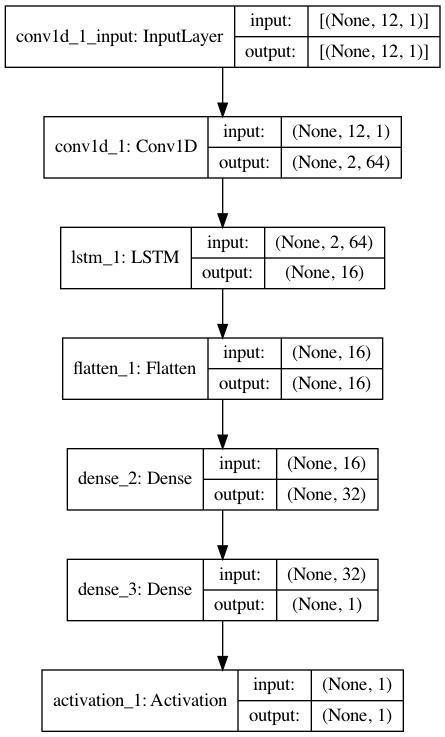

In [22]:
"""from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_conv_LSTM_plot.png', show_shapes=True, show_layer_names=True)"""

# Conv1d Model

In [12]:
def create_model(filters=64,kernel_size=5):
    model = Sequential([
    Conv1D(filters=filters, kernel_size=kernel_size,strides=8, activation='tanh',padding='same', input_shape=(df_features.shape[1], 1)),
    ZeroPadding1D(padding=1),
    LSTM(16,recurrent_dropout=0.1),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='swish'),
    Activation('sigmoid')])
    optimizer=SGD(lr=0.001)
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', auc_roc])
    return model

In [13]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=50, batch_size=32, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [14]:

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None


parameters = {
        #'scaling__type_of_scaling': ['standard'],
        #'outlier__outlier_threshold': [0.0, 3.0],
        #'features__k': [12,15],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        'model__batch_size': [32, 48],#usually multiple of 8
        'model__epochs':[50,60],
        'model__filters':[8,16,32,64],
        'model__kernel_size':[3,5,7],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

# Estimator Pipeline
pipeline = Pipeline(
      [
        #('progress', GridSearchProgressHack(verbose=False)),
        #('scaling',  FeatureScalerTransformer()),
        #('outlier',  WinsorizationOutlierTransformer()),
        #('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        #('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
# Cross Validation Splitter
cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        #cv = 5,
        refit = 'roc_auc',
        verbose = 1)

search.fit(df_features, mind_wandered_label, groups=participant_ids)
#search.fit(df_features, mind_wandered_label)

df = pd.DataFrame(data=search.cv_results_)
    
    
if best_estimator is None:
    df_result = df
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_
    best_index = search.best_index_
else:
    df_result = df_result.append(df, ignore_index=True)
    if search.best_score_ > best_score:
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_  # todo this is only the index of this search

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6921 - accuracy: 0.5148 - auc_roc: 0.5843
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5457 - auc_roc: 0.6067
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5484 - auc_roc: 0.6006
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5550 - auc_roc: 0.6136
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5396 - auc_roc: 0.6096
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5675 - auc_roc: 0.6202
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5490 - auc_roc: 0.6018
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5616 - auc_roc: 0.6183
Epoch 9/50

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6924 - accuracy: 0.5858 - auc_roc: 0.6405
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5773 - auc_roc: 0.5967
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.6006 - auc_roc: 0.6189
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5999 - auc_roc: 0.6287
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5917 - auc_roc: 0.6165
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.6293 - auc_roc: 0.6588
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.6208 - auc_roc: 0.6521
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.6413 - auc_roc: 0.6742
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6950 - accuracy: 0.3455 - auc_roc: 0.6392
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.3327 - auc_roc: 0.2612
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.3474 - auc_roc: 0.3000
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.3569 - auc_roc: 0.3118
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.3850 - auc_roc: 0.3455
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.3686 - auc_roc: 0.3387
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.3642 - auc_roc: 0.3549
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.3981 - auc_roc: 0.3863
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6936 - accuracy: 0.3915 - auc_roc: 0.6318
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4209 - auc_roc: 0.4713
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4387 - auc_roc: 0.5141
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.4490 - auc_roc: 0.5239
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4812 - auc_roc: 0.5456
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5131 - auc_roc: 0.5707
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5580 - auc_roc: 0.5972
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5624 - auc_roc: 0.5927
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 958us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6938 - accuracy: 0.4517 - auc_roc: 0.6745
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4500 - auc_roc: 0.4492
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4558 - auc_roc: 0.4548
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4591 - auc_roc: 0.4615
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4810 - auc_roc: 0.4734
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4820 - auc_roc: 0.4785
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.4705 - auc_roc: 0.4931
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4682 - auc_roc: 0.4803
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 953us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6934 - accuracy: 0.5032 - auc_roc: 0.5948
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4986 - auc_roc: 0.4973
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5054 - auc_roc: 0.5085
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5307 - auc_roc: 0.5327
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5348 - auc_roc: 0.5146
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5272 - auc_roc: 0.5115
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5473 - auc_roc: 0.5343
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5300 - auc_roc: 0.5238
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6925 - accuracy: 0.4660 - auc_roc: 0.5964
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.4902 - auc_roc: 0.6112
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4831 - auc_roc: 0.5819
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.4928 - auc_roc: 0.6175
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5040 - auc_roc: 0.6356
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5024 - auc_roc: 0.6360
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5338 - auc_roc: 0.6435
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5353 - auc_roc: 0.6416
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6948 - accuracy: 0.3843 - auc_roc: 0.6103
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4191 - auc_roc: 0.3562
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.4205 - auc_roc: 0.3730
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.4244 - auc_roc: 0.3993
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4150 - auc_roc: 0.3774
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4206 - auc_roc: 0.4082
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4384 - auc_roc: 0.4298
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4403 - auc_roc: 0.4413
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 937us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6918 - accuracy: 0.5892 - auc_roc: 0.6567
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5910 - auc_roc: 0.6183
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5686 - auc_roc: 0.6197
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5705 - auc_roc: 0.6373
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5901 - auc_roc: 0.6450
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5876 - auc_roc: 0.6516
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5939 - auc_roc: 0.6819
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5808 - auc_roc: 0.6615
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 965us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6962 - accuracy: 0.4434 - auc_roc: 0.6447
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4809 - auc_roc: 0.3695
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4430 - auc_roc: 0.3564
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.4485 - auc_roc: 0.3853
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.4315 - auc_roc: 0.3834
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4313 - auc_roc: 0.3693
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6950 - accuracy: 0.4317 - auc_roc: 0.3881
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.4438 - auc_roc: 0.3901
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6917 - accuracy: 0.5927 - auc_roc: 0.5832
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.6051 - auc_roc: 0.6780
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6090 - auc_roc: 0.6848
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6160 - auc_roc: 0.6828
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5951 - auc_roc: 0.6721
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5973 - auc_roc: 0.6717
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.6004 - auc_roc: 0.6863
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6088 - auc_roc: 0.6956
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 995us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6931 - accuracy: 0.5149 - auc_roc: 0.6422
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5260 - auc_roc: 0.5232
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5401 - auc_roc: 0.5395
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5539 - auc_roc: 0.5554
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5631 - auc_roc: 0.5508
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5495 - auc_roc: 0.5349
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5894 - auc_roc: 0.5695
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5882 - auc_roc: 0.5487
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6925 - accuracy: 0.5119 - auc_roc: 0.6247
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4918 - auc_roc: 0.5125
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.4827 - auc_roc: 0.4908
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5011 - auc_roc: 0.5347
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5024 - auc_roc: 0.5332
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5049 - auc_roc: 0.5360
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.4977 - auc_roc: 0.5329
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5158 - auc_roc: 0.5528
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6948 - accuracy: 0.5153 - auc_roc: 0.5927
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.5282 - auc_roc: 0.4357
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5751 - auc_roc: 0.4740
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.5467 - auc_roc: 0.4390
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5694 - auc_roc: 0.4604
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.5460 - auc_roc: 0.4718
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5560 - auc_roc: 0.4781
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5555 - auc_roc: 0.4702
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6918 - accuracy: 0.5317 - auc_roc: 0.6031
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5219 - auc_roc: 0.5505
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5414 - auc_roc: 0.5876
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5437 - auc_roc: 0.6073
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5392 - auc_roc: 0.6031
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5417 - auc_roc: 0.6195
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5257 - auc_roc: 0.6407
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5346 - auc_roc: 0.6489
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 964us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6946 - accuracy: 0.4855 - auc_roc: 0.6091
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4819 - auc_roc: 0.3819
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4887 - auc_roc: 0.3530
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4916 - auc_roc: 0.3619
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.4872 - auc_roc: 0.4022
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4877 - auc_roc: 0.4208
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4691 - auc_roc: 0.4224
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4879 - auc_roc: 0.4399
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6916 - accuracy: 0.6284 - auc_roc: 0.6595
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.6271 - auc_roc: 0.6756
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6457 - auc_roc: 0.6946
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.6238 - auc_roc: 0.6607
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.6061 - auc_roc: 0.6516
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.6294 - auc_roc: 0.6850
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.6236 - auc_roc: 0.6737
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.6164 - auc_roc: 0.6769
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 968us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6927 - accuracy: 0.4799 - auc_roc: 0.6433
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4843 - auc_roc: 0.5089
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4918 - auc_roc: 0.5083
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4984 - auc_roc: 0.5117
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5098 - auc_roc: 0.5258
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5250 - auc_roc: 0.5535
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5039 - auc_roc: 0.5433
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5315 - auc_roc: 0.5734
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 971us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6945 - accuracy: 0.4145 - auc_roc: 0.5946
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.3960 - auc_roc: 0.3765
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.4037 - auc_roc: 0.3852
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4249 - auc_roc: 0.4078
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4355 - auc_roc: 0.4216
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4292 - auc_roc: 0.4050
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.4457 - auc_roc: 0.4169
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4619 - auc_roc: 0.4459
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 993us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6954 - accuracy: 0.4092 - auc_roc: 0.5483
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4300 - auc_roc: 0.3136
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4537 - auc_roc: 0.3153
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4364 - auc_roc: 0.2990
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4332 - auc_roc: 0.3201
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4595 - auc_roc: 0.3442
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4401 - auc_roc: 0.3496
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4260 - auc_roc: 0.3472
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6945 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 949us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6929 - accuracy: 0.5202 - auc_roc: 0.6243
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5262 - auc_roc: 0.5097
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5069 - auc_roc: 0.4977
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5132 - auc_roc: 0.5037
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5318 - auc_roc: 0.5151
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5060 - auc_roc: 0.5010
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4998 - auc_roc: 0.4833
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5174 - auc_roc: 0.5247
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 916us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6935 - accuracy: 0.4531 - auc_roc: 0.5682
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5016 - auc_roc: 0.4996
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5310 - auc_roc: 0.5242
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5855 - auc_roc: 0.5637
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5689 - auc_roc: 0.5429
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5893 - auc_roc: 0.5586
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5847 - auc_roc: 0.5738
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5987 - auc_roc: 0.5831
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 947us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6907 - accuracy: 0.6437 - auc_roc: 0.7014
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.6540 - auc_roc: 0.7119
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.6489 - auc_roc: 0.7000
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.6677 - auc_roc: 0.7146
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.6544 - auc_roc: 0.7061
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.6666 - auc_roc: 0.7270
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.6589 - auc_roc: 0.7069
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.6685 - auc_roc: 0.7192
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6897 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 986us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6911 - accuracy: 0.5385 - auc_roc: 0.7271
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5547 - auc_roc: 0.6823
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5524 - auc_roc: 0.6722
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5858 - auc_roc: 0.6757
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5976 - auc_roc: 0.6917
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5990 - auc_roc: 0.6931
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5833 - auc_roc: 0.6707
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5914 - auc_roc: 0.6803
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6907 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 940us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6936 - accuracy: 0.4898 - auc_roc: 0.6419
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5026 - auc_roc: 0.5314
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4946 - auc_roc: 0.5309
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5062 - auc_roc: 0.5286
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5238 - auc_roc: 0.5610
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5195 - auc_roc: 0.5528
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5085 - auc_roc: 0.5500
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5161 - auc_roc: 0.5642
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6930 - accuracy: 0.5452 - auc_roc: 0.6189
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5419 - auc_roc: 0.5599
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5668 - auc_roc: 0.5677
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5728 - auc_roc: 0.5743
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5488 - auc_roc: 0.5469
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5669 - auc_roc: 0.5719
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5776 - auc_roc: 0.5628
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5731 - auc_roc: 0.5805
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6926 - accuracy: 0.5677 - auc_roc: 0.6141
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5871 - auc_roc: 0.5732
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.6138 - auc_roc: 0.6161
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.6044 - auc_roc: 0.6119
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.6214 - auc_roc: 0.6327
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.6278 - auc_roc: 0.6489
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6137 - auc_roc: 0.6461
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.6116 - auc_roc: 0.6605
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 963us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6928 - accuracy: 0.4619 - auc_roc: 0.6685
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5016 - auc_roc: 0.5470
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4943 - auc_roc: 0.5674
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4851 - auc_roc: 0.5594
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.4897 - auc_roc: 0.5849
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5142 - auc_roc: 0.5989
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.4990 - auc_roc: 0.5560
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5161 - auc_roc: 0.5861
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 913us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6929 - accuracy: 0.5101 - auc_roc: 0.6259
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5129 - auc_roc: 0.5027
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5163 - auc_roc: 0.5183
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5306 - auc_roc: 0.5444
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5270 - auc_roc: 0.5398
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5296 - auc_roc: 0.5438
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5450 - auc_roc: 0.5509
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5272 - auc_roc: 0.5580
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6942 - accuracy: 0.4462 - auc_roc: 0.6104
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4520 - auc_roc: 0.4207
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4752 - auc_roc: 0.4631
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4587 - auc_roc: 0.4510
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4600 - auc_roc: 0.4584
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4867 - auc_roc: 0.4629
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4773 - auc_roc: 0.4732
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4630 - auc_roc: 0.4680
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 942us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6923 - accuracy: 0.5239 - auc_roc: 0.6247
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5095 - auc_roc: 0.6144
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5093 - auc_roc: 0.6473
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5219 - auc_roc: 0.6487
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5325 - auc_roc: 0.6638
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5336 - auc_roc: 0.6577
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5294 - auc_roc: 0.6768
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5202 - auc_roc: 0.6883
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 908us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6934 - accuracy: 0.5088 - auc_roc: 0.6185
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5184 - auc_roc: 0.5065
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5252 - auc_roc: 0.5107
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5502 - auc_roc: 0.5131
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5313 - auc_roc: 0.5228
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5289 - auc_roc: 0.5380
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5359 - auc_roc: 0.5371
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5185 - auc_roc: 0.5462
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 953us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6932 - accuracy: 0.4884 - auc_roc: 0.6422
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5065 - auc_roc: 0.5902
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5141 - auc_roc: 0.6137
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5178 - auc_roc: 0.6111
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5444 - auc_roc: 0.6203
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5568 - auc_roc: 0.6475
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5670 - auc_roc: 0.6561
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5844 - auc_roc: 0.6598
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6940 - accuracy: 0.4153 - auc_roc: 0.6475
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4118 - auc_roc: 0.3868
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4264 - auc_roc: 0.4088
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4391 - auc_roc: 0.4143
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4737 - auc_roc: 0.4346
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4906 - auc_roc: 0.4509
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5284 - auc_roc: 0.4613
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5356 - auc_roc: 0.4758
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 963us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6936 - accuracy: 0.5149 - auc_roc: 0.6263
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5384 - auc_roc: 0.5416
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5643 - auc_roc: 0.5712
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5474 - auc_roc: 0.5557
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5693 - auc_roc: 0.5790
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5696 - auc_roc: 0.5683
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5887 - auc_roc: 0.5973
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5718 - auc_roc: 0.5795
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6932 - accuracy: 0.5005 - auc_roc: 0.6233
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5028 - auc_roc: 0.5240
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5164 - auc_roc: 0.5471
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5333 - auc_roc: 0.5556
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5550 - auc_roc: 0.5672
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5651 - auc_roc: 0.5767
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5689 - auc_roc: 0.5898
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5917 - auc_roc: 0.6019
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6924 - accuracy: 0.4867 - auc_roc: 0.6808
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4875 - auc_roc: 0.6711
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5257 - auc_roc: 0.6608
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5545 - auc_roc: 0.6568
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5697 - auc_roc: 0.6859
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5935 - auc_roc: 0.7014
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.6012 - auc_roc: 0.7302
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6346 - auc_roc: 0.7307
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6923 - accuracy: 0.5483 - auc_roc: 0.6908
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5537 - auc_roc: 0.5592
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5419 - auc_roc: 0.5442
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5700 - auc_roc: 0.5956
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5555 - auc_roc: 0.5759
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5873 - auc_roc: 0.6277
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5836 - auc_roc: 0.6104
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5480 - auc_roc: 0.6150
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6923 - accuracy: 0.5493 - auc_roc: 0.6532
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5750 - auc_roc: 0.5936
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5644 - auc_roc: 0.5624
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5751 - auc_roc: 0.5875
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5734 - auc_roc: 0.5697
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5834 - auc_roc: 0.6002
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5726 - auc_roc: 0.5901
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5820 - auc_roc: 0.6041
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6930 - accuracy: 0.4612 - auc_roc: 0.6319
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4795 - auc_roc: 0.5049
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.4843 - auc_roc: 0.5365
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.4820 - auc_roc: 0.5473
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.4972 - auc_roc: 0.5459
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5024 - auc_roc: 0.5754
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.4926 - auc_roc: 0.5914
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5056 - auc_roc: 0.5963
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6956 - accuracy: 0.3586 - auc_roc: 0.5915
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.3604 - auc_roc: 0.2557
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.3789 - auc_roc: 0.2523
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4009 - auc_roc: 0.2780
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6950 - accuracy: 0.3776 - auc_roc: 0.2639
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.3905 - auc_roc: 0.2696
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4025 - auc_roc: 0.2716
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.4082 - auc_roc: 0.3062
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6928 - accuracy: 0.5648 - auc_roc: 0.6214
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5467 - auc_roc: 0.5319
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5785 - auc_roc: 0.5613
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5906 - auc_roc: 0.5834
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5805 - auc_roc: 0.5624
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5826 - auc_roc: 0.5902
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5596 - auc_roc: 0.6000
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5668 - auc_roc: 0.5973
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6917 - accuracy: 0.5551 - auc_roc: 0.6555
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5677 - auc_roc: 0.6834
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5614 - auc_roc: 0.6726
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5701 - auc_roc: 0.7037
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5566 - auc_roc: 0.7064
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5499 - auc_roc: 0.7187
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5610 - auc_roc: 0.7075
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5698 - auc_roc: 0.7503
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6907 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6958 - accuracy: 0.4096 - auc_roc: 0.6440
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.4188 - auc_roc: 0.3751
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4269 - auc_roc: 0.3506
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.4574 - auc_roc: 0.3665
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4838 - auc_roc: 0.3928
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.5076 - auc_roc: 0.3950
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5031 - auc_roc: 0.3857
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5314 - auc_roc: 0.4219
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 991us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 6ms/step - loss: 0.6923 - accuracy: 0.5271 - auc_roc: 0.6250
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5351 - auc_roc: 0.5647
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5514 - auc_roc: 0.5872
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5586 - auc_roc: 0.6110
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5733 - auc_roc: 0.6416
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5598 - auc_roc: 0.6196
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5637 - auc_roc: 0.6268
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5650 - auc_roc: 0.6678
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 956us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6946 - accuracy: 0.4479 - auc_roc: 0.6021
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4551 - auc_roc: 0.4113
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.4506 - auc_roc: 0.3898
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.4604 - auc_roc: 0.4159
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.4482 - auc_roc: 0.4163
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4252 - auc_roc: 0.4069
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4337 - auc_roc: 0.4166
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4677 - auc_roc: 0.4499
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 953us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6944 - accuracy: 0.4156 - auc_roc: 0.5521
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4315 - auc_roc: 0.4185
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4268 - auc_roc: 0.4279
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4067 - auc_roc: 0.4231
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4427 - auc_roc: 0.4782
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4263 - auc_roc: 0.4688
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.4622 - auc_roc: 0.4900
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4803 - auc_roc: 0.5275
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 997us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6932 - accuracy: 0.5355 - auc_roc: 0.6789
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5441 - auc_roc: 0.5355
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5586 - auc_roc: 0.5530
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5489 - auc_roc: 0.5703
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5335 - auc_roc: 0.5578
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5633 - auc_roc: 0.6055
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5657 - auc_roc: 0.5852
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5869 - auc_roc: 0.6164
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 951us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6898 - accuracy: 0.6185 - auc_roc: 0.6578
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.6139 - auc_roc: 0.7008
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.6159 - auc_roc: 0.7049
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.6103 - auc_roc: 0.7112
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.6205 - auc_roc: 0.7255
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.6273 - auc_roc: 0.7142
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.6053 - auc_roc: 0.7146
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.6313 - auc_roc: 0.7215
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6883 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 962us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6915 - accuracy: 0.4707 - auc_roc: 0.6844
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.4753 - auc_roc: 0.5703
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.4766 - auc_roc: 0.5906
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5203 - auc_roc: 0.5961
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.4955 - auc_roc: 0.5772
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5287 - auc_roc: 0.6051
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5369 - auc_roc: 0.6189
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5163 - auc_roc: 0.6359
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6894 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6938 - accuracy: 0.4660 - auc_roc: 0.5930
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.5313 - auc_roc: 0.4889
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5264 - auc_roc: 0.4924
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5405 - auc_roc: 0.5258
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5353 - auc_roc: 0.5280
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5545 - auc_roc: 0.5492
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5410 - auc_roc: 0.5455
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5546 - auc_roc: 0.5517
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6927 - accuracy: 0.5460 - auc_roc: 0.6728
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5621 - auc_roc: 0.5392
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.6097 - auc_roc: 0.5804
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5830 - auc_roc: 0.5402
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.6149 - auc_roc: 0.5714
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5963 - auc_roc: 0.5600
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5967 - auc_roc: 0.5759
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.6032 - auc_roc: 0.5949
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6920 - accuracy: 0.5770 - auc_roc: 0.6747
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5854 - auc_roc: 0.6228
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5823 - auc_roc: 0.6212
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5611 - auc_roc: 0.6233
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5674 - auc_roc: 0.6609
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5725 - auc_roc: 0.6660
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5599 - auc_roc: 0.6821
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5766 - auc_roc: 0.6577
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6938 - accuracy: 0.4204 - auc_roc: 0.6278
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4392 - auc_roc: 0.4251
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4520 - auc_roc: 0.4379
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4636 - auc_roc: 0.4423
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5018 - auc_roc: 0.4803
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5058 - auc_roc: 0.4795
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5031 - auc_roc: 0.4624
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5265 - auc_roc: 0.4954
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6942 - accuracy: 0.4848 - auc_roc: 0.6238
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4780 - auc_roc: 0.4237
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4900 - auc_roc: 0.4696
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4688 - auc_roc: 0.4681
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4879 - auc_roc: 0.4814
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5161 - auc_roc: 0.5161
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5079 - auc_roc: 0.5253
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5152 - auc_roc: 0.5466
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 977us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6922 - accuracy: 0.5899 - auc_roc: 0.6499
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.6093 - auc_roc: 0.6608
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.6095 - auc_roc: 0.6569
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.6176 - auc_roc: 0.6732
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.6410 - auc_roc: 0.6868
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.6301 - auc_roc: 0.6752
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6370 - auc_roc: 0.6875
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6409 - auc_roc: 0.6799
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6938 - accuracy: 0.4302 - auc_roc: 0.6663
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4474 - auc_roc: 0.4576
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4830 - auc_roc: 0.4959
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4597 - auc_roc: 0.4824
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5091 - auc_roc: 0.5240
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5316 - auc_roc: 0.5376
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5308 - auc_roc: 0.5417
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5359 - auc_roc: 0.5431
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6913 - accuracy: 0.6700 - auc_roc: 0.6966
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6668 - auc_roc: 0.7529
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.6542 - auc_roc: 0.7446
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6587 - auc_roc: 0.7388
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.6705 - auc_roc: 0.7604
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.6676 - auc_roc: 0.7539
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.6611 - auc_roc: 0.7774
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.6404 - auc_roc: 0.7533
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6902 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6937 - accuracy: 0.5355 - auc_roc: 0.6477
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.5455 - auc_roc: 0.4562
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5356 - auc_roc: 0.4390
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5236 - auc_roc: 0.4367
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5478 - auc_roc: 0.4789
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5304 - auc_roc: 0.4899
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5355 - auc_roc: 0.5010
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5391 - auc_roc: 0.4916
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6935 - accuracy: 0.5066 - auc_roc: 0.6387
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5019 - auc_roc: 0.4949
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5214 - auc_roc: 0.5158
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5387 - auc_roc: 0.5333
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5451 - auc_roc: 0.5347
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5576 - auc_roc: 0.5603
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5361 - auc_roc: 0.5278
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5567 - auc_roc: 0.5718
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 948us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6916 - accuracy: 0.5932 - auc_roc: 0.6206
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5924 - auc_roc: 0.6195
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.6078 - auc_roc: 0.6432
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.6265 - auc_roc: 0.6535
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.6393 - auc_roc: 0.6650
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.6154 - auc_roc: 0.6427
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.6254 - auc_roc: 0.6493
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.6318 - auc_roc: 0.6645
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6907 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6928 - accuracy: 0.5690 - auc_roc: 0.6440
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5833 - auc_roc: 0.5950
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5940 - auc_roc: 0.6018
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.6086 - auc_roc: 0.6222
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.6055 - auc_roc: 0.6430
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5838 - auc_roc: 0.6142
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5806 - auc_roc: 0.6420
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5935 - auc_roc: 0.6411
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 918us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6933 - accuracy: 0.5428 - auc_roc: 0.6628
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5448 - auc_roc: 0.5297
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5502 - auc_roc: 0.5415
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5458 - auc_roc: 0.5281
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5511 - auc_roc: 0.5337
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5672 - auc_roc: 0.5562
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5726 - auc_roc: 0.5507
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5722 - auc_roc: 0.5519
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 940us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6955 - accuracy: 0.3447 - auc_roc: 0.5546
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.3311 - auc_roc: 0.3015
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.3478 - auc_roc: 0.3066
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.3642 - auc_roc: 0.3325
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.3556 - auc_roc: 0.3111
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.3590 - auc_roc: 0.3106
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.3872 - auc_roc: 0.3313
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6950 - accuracy: 0.3978 - auc_roc: 0.3333
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6947 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 919us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6946 - accuracy: 0.4647 - auc_roc: 0.5274
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.4744 - auc_roc: 0.4669
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5080 - auc_roc: 0.4681
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4888 - auc_roc: 0.4923
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5011 - auc_roc: 0.4972
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5114 - auc_roc: 0.5019
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4849 - auc_roc: 0.5231
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5019 - auc_roc: 0.5112
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6944 - accuracy: 0.3640 - auc_roc: 0.5958
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.3505 - auc_roc: 0.3181
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.3516 - auc_roc: 0.3376
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.3604 - auc_roc: 0.3502
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.3690 - auc_roc: 0.3643
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.3903 - auc_roc: 0.3816
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4055 - auc_roc: 0.3708
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4064 - auc_roc: 0.3855
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 965us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6936 - accuracy: 0.4645 - auc_roc: 0.6242
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4661 - auc_roc: 0.4612
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4855 - auc_roc: 0.4855
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5039 - auc_roc: 0.5146
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5159 - auc_roc: 0.5384
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5296 - auc_roc: 0.5446
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5284 - auc_roc: 0.5398
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5566 - auc_roc: 0.5776
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 961us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6940 - accuracy: 0.4521 - auc_roc: 0.6489
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4565 - auc_roc: 0.4683
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4518 - auc_roc: 0.4579
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4506 - auc_roc: 0.4609
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4626 - auc_roc: 0.4771
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4634 - auc_roc: 0.4833
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4659 - auc_roc: 0.4795
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4785 - auc_roc: 0.4847
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 989us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6926 - accuracy: 0.5481 - auc_roc: 0.5945
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5600 - auc_roc: 0.5508
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5477 - auc_roc: 0.5087
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5419 - auc_roc: 0.5239
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5347 - auc_roc: 0.5332
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5577 - auc_roc: 0.5264
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5532 - auc_roc: 0.5225
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5575 - auc_roc: 0.5260
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 993us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6934 - accuracy: 0.4803 - auc_roc: 0.5931
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4789 - auc_roc: 0.4793
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4979 - auc_roc: 0.4871
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4721 - auc_roc: 0.4874
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5101 - auc_roc: 0.5035
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4908 - auc_roc: 0.4919
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5182 - auc_roc: 0.5040
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5340 - auc_roc: 0.5209
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6930 - accuracy: 0.4790 - auc_roc: 0.5666
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4977 - auc_roc: 0.5228
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5148 - auc_roc: 0.5596
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4952 - auc_roc: 0.5310
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5152 - auc_roc: 0.5600
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5194 - auc_roc: 0.5637
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5104 - auc_roc: 0.5530
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5132 - auc_roc: 0.5674
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 969us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6923 - accuracy: 0.5413 - auc_roc: 0.6169
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5314 - auc_roc: 0.5576
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5445 - auc_roc: 0.5529
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5390 - auc_roc: 0.5484
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5923 - auc_roc: 0.5905
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5855 - auc_roc: 0.5799
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5971 - auc_roc: 0.6068
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5800 - auc_roc: 0.5830
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 982us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6929 - accuracy: 0.5318 - auc_roc: 0.6445
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5156 - auc_roc: 0.4725
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5276 - auc_roc: 0.5134
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5364 - auc_roc: 0.5196
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5393 - auc_roc: 0.5507
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5344 - auc_roc: 0.5848
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5178 - auc_roc: 0.5883
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5233 - auc_roc: 0.6371
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6930 - accuracy: 0.4525 - auc_roc: 0.6675
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4644 - auc_roc: 0.5441
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.4846 - auc_roc: 0.5596
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4987 - auc_roc: 0.5875
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5189 - auc_roc: 0.5819
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5324 - auc_roc: 0.5771
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5544 - auc_roc: 0.5832
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5501 - auc_roc: 0.5814
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 972us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6940 - accuracy: 0.4134 - auc_roc: 0.6208
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4417 - auc_roc: 0.4288
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4581 - auc_roc: 0.4417
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4654 - auc_roc: 0.4453
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4778 - auc_roc: 0.4483
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4786 - auc_roc: 0.4387
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4803 - auc_roc: 0.4592
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4770 - auc_roc: 0.4671
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6919 - accuracy: 0.5703 - auc_roc: 0.6507
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5854 - auc_roc: 0.5691
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5719 - auc_roc: 0.5822
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5682 - auc_roc: 0.5721
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5619 - auc_roc: 0.5559
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5767 - auc_roc: 0.5803
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5809 - auc_roc: 0.5793
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5857 - auc_roc: 0.6023
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 981us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6926 - accuracy: 0.4914 - auc_roc: 0.6459
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.4760 - auc_roc: 0.5989
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.4955 - auc_roc: 0.5924
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5384 - auc_roc: 0.6420
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5462 - auc_roc: 0.6478
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5476 - auc_roc: 0.6238
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5469 - auc_roc: 0.6480
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5707 - auc_roc: 0.6564
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 986us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6921 - accuracy: 0.5721 - auc_roc: 0.6863
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5925 - auc_roc: 0.7118
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5854 - auc_roc: 0.7288
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.6106 - auc_roc: 0.7335
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5900 - auc_roc: 0.7210
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5939 - auc_roc: 0.7368
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5872 - auc_roc: 0.7383
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5951 - auc_roc: 0.7283
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6905 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 6ms/step - loss: 0.6938 - accuracy: 0.4427 - auc_roc: 0.6421
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4656 - auc_roc: 0.4383
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5090 - auc_roc: 0.4671
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4966 - auc_roc: 0.4449
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5463 - auc_roc: 0.4862
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5804 - auc_roc: 0.5354
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5380 - auc_roc: 0.5213
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5807 - auc_roc: 0.5492
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 949us/step
Epoch 1/60
55/55 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.4951 - auc_roc: 0.6556
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.4831 - auc_roc: 0.5268
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.4846 - auc_roc: 0.5097
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.4801 - auc_roc: 0.5125
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5233 - auc_roc: 0.5650
Epoch 6/60
55/55 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5296 - auc_roc: 0.5652
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5230 - auc_roc: 0.5749
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5366 - auc_roc: 0.5934
Epoch 9/60
55/55 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 917us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6954 - accuracy: 0.3376 - auc_roc: 0.5718
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.3764 - auc_roc: 0.3099
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.3723 - auc_roc: 0.3178
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.3722 - auc_roc: 0.3150
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.3654 - auc_roc: 0.3095
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.3783 - auc_roc: 0.3231
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.3684 - auc_roc: 0.3279
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.3624 - auc_roc: 0.3223
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6944 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 959us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 6ms/step - loss: 0.6926 - accuracy: 0.5426 - auc_roc: 0.6293
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5602 - auc_roc: 0.5735
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5708 - auc_roc: 0.5793
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5541 - auc_roc: 0.5628
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5553 - auc_roc: 0.5539
Epoch 6/60
55/55 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5468 - auc_roc: 0.5458
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5647 - auc_roc: 0.5628
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5641 - auc_roc: 0.5763
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 6ms/step - loss: 0.6932 - accuracy: 0.4751 - auc_roc: 0.6244
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.4533 - auc_roc: 0.5305
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4705 - auc_roc: 0.5602
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4549 - auc_roc: 0.5791
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.4753 - auc_roc: 0.5905
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.4804 - auc_roc: 0.5937
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4814 - auc_roc: 0.5700
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5022 - auc_roc: 0.6163
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6926 - accuracy: 0.4748 - auc_roc: 0.6906
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4577 - auc_roc: 0.5995
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4824 - auc_roc: 0.6049
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4861 - auc_roc: 0.6085
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.4762 - auc_roc: 0.6547
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.4998 - auc_roc: 0.6445
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5160 - auc_roc: 0.6513
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5316 - auc_roc: 0.6763
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 975us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6929 - accuracy: 0.4815 - auc_roc: 0.6732
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.4866 - auc_roc: 0.4957
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5086 - auc_roc: 0.5099
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5538 - auc_roc: 0.5812
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5257 - auc_roc: 0.5419
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5532 - auc_roc: 0.5794
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5826 - auc_roc: 0.5881
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5945 - auc_roc: 0.5979
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 924us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6946 - accuracy: 0.4782 - auc_roc: 0.5964
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4969 - auc_roc: 0.4103
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5201 - auc_roc: 0.4248
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4944 - auc_roc: 0.4439
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4855 - auc_roc: 0.4550
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5318 - auc_roc: 0.4987
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4910 - auc_roc: 0.4684
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5091 - auc_roc: 0.4975
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 932us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6937 - accuracy: 0.5226 - auc_roc: 0.6044
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5552 - auc_roc: 0.4928
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5411 - auc_roc: 0.4766
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5499 - auc_roc: 0.4945
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5740 - auc_roc: 0.5136
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5589 - auc_roc: 0.5124
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5911 - auc_roc: 0.5282
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5611 - auc_roc: 0.5149
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 891us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6944 - accuracy: 0.4839 - auc_roc: 0.6112
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5121 - auc_roc: 0.4509
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5127 - auc_roc: 0.4317
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5308 - auc_roc: 0.4489
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5064 - auc_roc: 0.4672
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4923 - auc_roc: 0.4786
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5269 - auc_roc: 0.5221
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4947 - auc_roc: 0.4956
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 985us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6955 - accuracy: 0.3495 - auc_roc: 0.6109
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.3695 - auc_roc: 0.2720
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.4042 - auc_roc: 0.2724
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4188 - auc_roc: 0.2790
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4443 - auc_roc: 0.2777
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4483 - auc_roc: 0.2883
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4780 - auc_roc: 0.2629
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.4814 - auc_roc: 0.3069
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 793us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6956 - accuracy: 0.4225 - auc_roc: 0.5808
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.3781 - auc_roc: 0.3253
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.4157 - auc_roc: 0.3383
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4282 - auc_roc: 0.3448
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.3968 - auc_roc: 0.3377
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4016 - auc_roc: 0.3474
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4093 - auc_roc: 0.3534
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4201 - auc_roc: 0.3647
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6952 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6948 - accuracy: 0.4168 - auc_roc: 0.5201
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.4181 - auc_roc: 0.4067
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4445 - auc_roc: 0.4267
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4492 - auc_roc: 0.4359
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4534 - auc_roc: 0.4381
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4732 - auc_roc: 0.4446
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4686 - auc_roc: 0.4375
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4849 - auc_roc: 0.4583
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6941 - accuracy: 0.3952 - auc_roc: 0.6397
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4198 - auc_roc: 0.4232
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4448 - auc_roc: 0.4619
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4452 - auc_roc: 0.4735
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4637 - auc_roc: 0.4704
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5204 - auc_roc: 0.5108
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4958 - auc_roc: 0.5269
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4934 - auc_roc: 0.5113
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6933 - accuracy: 0.4652 - auc_roc: 0.6292
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4913 - auc_roc: 0.4540
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4856 - auc_roc: 0.4427
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4939 - auc_roc: 0.4696
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4789 - auc_roc: 0.4736
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5288 - auc_roc: 0.4893
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5128 - auc_roc: 0.5002
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5036 - auc_roc: 0.5224
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 909us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6952 - accuracy: 0.3641 - auc_roc: 0.6170
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.3663 - auc_roc: 0.3103
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4094 - auc_roc: 0.3353
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4344 - auc_roc: 0.3538
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4437 - auc_roc: 0.3562
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4500 - auc_roc: 0.3543
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4719 - auc_roc: 0.3845
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.4847 - auc_roc: 0.3809
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 952us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 7ms/step - loss: 0.6935 - accuracy: 0.4753 - auc_roc: 0.6365
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5003 - auc_roc: 0.5835
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4957 - auc_roc: 0.5631
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5289 - auc_roc: 0.5809
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5355 - auc_roc: 0.5785
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5397 - auc_roc: 0.5973
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5545 - auc_roc: 0.5781
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5539 - auc_roc: 0.6051
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 941us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 3s 6ms/step - loss: 0.6940 - accuracy: 0.4408 - auc_roc: 0.5888
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4484 - auc_roc: 0.4281
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4618 - auc_roc: 0.4595
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4710 - auc_roc: 0.4607
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4974 - auc_roc: 0.4608
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5220 - auc_roc: 0.4841
Epoch 7/60
55/55 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5337 - auc_roc: 0.5010
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5325 - auc_roc: 0.5223
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 968us/step
Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6911 - accuracy: 0.6182 - auc_roc: 0.6847
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.6379 - auc_roc: 0.6708
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.6495 - auc_roc: 0.7022
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.6400 - auc_roc: 0.6933
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.6475 - auc_roc: 0.6954
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.6618 - auc_roc: 0.7099
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.6572 - auc_roc: 0.7203
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.6475 - auc_roc: 0.7173
Epoch 9/60
55/55 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6944 - accuracy: 0.4671 - auc_roc: 0.6780
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.4651 - auc_roc: 0.4856
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4684 - auc_roc: 0.5065
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4708 - auc_roc: 0.5050
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4744 - auc_roc: 0.4969
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4615 - auc_roc: 0.5230
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4722 - auc_roc: 0.5533
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4742 - auc_roc: 0.5416
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 973us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6918 - accuracy: 0.6082 - auc_roc: 0.6933
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.6263 - auc_roc: 0.6451
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6394 - auc_roc: 0.6727
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6126 - auc_roc: 0.6382
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.6253 - auc_roc: 0.6414
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.6306 - auc_roc: 0.6605
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6199 - auc_roc: 0.6507
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.6443 - auc_roc: 0.6737
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6959 - accuracy: 0.4042 - auc_roc: 0.6254
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.3944 - auc_roc: 0.3397
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 0.4165 - auc_roc: 0.3695
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.4115 - auc_roc: 0.3551
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.4247 - auc_roc: 0.3726
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.4217 - auc_roc: 0.3676
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4216 - auc_roc: 0.3738
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6950 - accuracy: 0.4400 - auc_roc: 0.4147
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 6ms/step - loss: 0.6916 - accuracy: 0.4995 - auc_roc: 0.6398
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5273 - auc_roc: 0.6508
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.5216 - auc_roc: 0.6559
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5298 - auc_roc: 0.6459
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5336 - auc_roc: 0.6638
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5464 - auc_roc: 0.6662
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5406 - auc_roc: 0.6650
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5229 - auc_roc: 0.6851
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6900 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 970us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6934 - accuracy: 0.4729 - auc_roc: 0.6318
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4782 - auc_roc: 0.4708
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5123 - auc_roc: 0.4987
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5343 - auc_roc: 0.4990
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5379 - auc_roc: 0.5229
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5082 - auc_roc: 0.5027
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5715 - auc_roc: 0.5447
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5485 - auc_roc: 0.5557
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6923 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 900us/step
Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6935 - accuracy: 0.4458 - auc_roc: 0.6324
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.4292 - auc_roc: 0.4124
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4623 - auc_roc: 0.4228
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4318 - auc_roc: 0.4298
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4504 - auc_roc: 0.4606
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4553 - auc_roc: 0.4552
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4785 - auc_roc: 0.4404
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.4863 - auc_roc: 0.4763
Epoch 9/60
55/55 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6922 - accuracy: 0.6058 - auc_roc: 0.6631
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.6070 - auc_roc: 0.5804
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.6287 - auc_roc: 0.5766
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5973 - auc_roc: 0.5744
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.6137 - auc_roc: 0.5867
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.6413 - auc_roc: 0.6184
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.6195 - auc_roc: 0.6028
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.6326 - auc_roc: 0.6247
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6933 - accuracy: 0.4879 - auc_roc: 0.6811
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4867 - auc_roc: 0.4718
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4954 - auc_roc: 0.4900
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4778 - auc_roc: 0.4821
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.4894 - auc_roc: 0.5273
Epoch 6/60
55/55 [==============================] - 1s 10ms/step - loss: 0.6926 - accuracy: 0.5174 - auc_roc: 0.5388
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5016 - auc_roc: 0.5344
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5284 - auc_roc: 0.5542
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss:

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6927 - accuracy: 0.4907 - auc_roc: 0.6462
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.4867 - auc_roc: 0.5107
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5076 - auc_roc: 0.5488
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4876 - auc_roc: 0.5310
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5319 - auc_roc: 0.5671
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5370 - auc_roc: 0.5856
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5410 - auc_roc: 0.5885
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5612 - auc_roc: 0.5889
Epoch 9/60
55/55 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 972us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6939 - accuracy: 0.3920 - auc_roc: 0.6227
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4037 - auc_roc: 0.3909
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4241 - auc_roc: 0.3756
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4496 - auc_roc: 0.3942
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4922 - auc_roc: 0.4366
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5248 - auc_roc: 0.4474
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5352 - auc_roc: 0.4232
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5226 - auc_roc: 0.4480
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 920us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6928 - accuracy: 0.5509 - auc_roc: 0.6171
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5198 - auc_roc: 0.4453
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5487 - auc_roc: 0.4747
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5306 - auc_roc: 0.4980
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5467 - auc_roc: 0.5286
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5346 - auc_roc: 0.5961
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5303 - auc_roc: 0.6222
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5624 - auc_roc: 0.6289
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 919us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6945 - accuracy: 0.3724 - auc_roc: 0.6231
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.3831 - auc_roc: 0.3516
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4109 - auc_roc: 0.3724
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4208 - auc_roc: 0.3808
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4253 - auc_roc: 0.4097
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4224 - auc_roc: 0.4216
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4344 - auc_roc: 0.4193
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4533 - auc_roc: 0.4575
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 911us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6935 - accuracy: 0.4455 - auc_roc: 0.6385
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4648 - auc_roc: 0.4443
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4705 - auc_roc: 0.4204
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4739 - auc_roc: 0.4297
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4791 - auc_roc: 0.4310
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4967 - auc_roc: 0.4657
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5090 - auc_roc: 0.4562
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.4938 - auc_roc: 0.4596
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 912us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6949 - accuracy: 0.3863 - auc_roc: 0.5382
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.3521 - auc_roc: 0.2979
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4018 - auc_roc: 0.3259
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.3847 - auc_roc: 0.3163
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.3939 - auc_roc: 0.3523
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4017 - auc_roc: 0.3535
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.3896 - auc_roc: 0.3524
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.3981 - auc_roc: 0.3554
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6940 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 996us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6932 - accuracy: 0.4648 - auc_roc: 0.6566
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4999 - auc_roc: 0.5867
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.4801 - auc_roc: 0.5753
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4903 - auc_roc: 0.5913
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5639 - auc_roc: 0.6289
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5769 - auc_roc: 0.6364
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.6205 - auc_roc: 0.6754
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.6274 - auc_roc: 0.6714
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6920 - accuracy: 0.5885 - auc_roc: 0.6786
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.6016 - auc_roc: 0.6289
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.6055 - auc_roc: 0.6436
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5875 - auc_roc: 0.6344
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.6218 - auc_roc: 0.6667
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.6150 - auc_roc: 0.6597
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.6173 - auc_roc: 0.6667
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.6206 - auc_roc: 0.6672
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 933us/step
Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6932 - accuracy: 0.4929 - auc_roc: 0.6415
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5409 - auc_roc: 0.5435
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5486 - auc_roc: 0.5594
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5564 - auc_roc: 0.5717
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5808 - auc_roc: 0.6048
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5658 - auc_roc: 0.6025
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5967 - auc_roc: 0.6316
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5985 - auc_roc: 0.6110
Epoch 9/60
55/55 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6945 - accuracy: 0.4814 - auc_roc: 0.6496
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4620 - auc_roc: 0.4407
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4892 - auc_roc: 0.4814
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4867 - auc_roc: 0.4634
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4959 - auc_roc: 0.4795
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4919 - auc_roc: 0.4866
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5232 - auc_roc: 0.4943
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5003 - auc_roc: 0.5012
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 898us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 6ms/step - loss: 0.6927 - accuracy: 0.5375 - auc_roc: 0.6196
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5283 - auc_roc: 0.5391
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5202 - auc_roc: 0.5414
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5051 - auc_roc: 0.5331
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5560 - auc_roc: 0.5780
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5235 - auc_roc: 0.5551
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5310 - auc_roc: 0.5960
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5183 - auc_roc: 0.5772
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6928 - accuracy: 0.4545 - auc_roc: 0.6575
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.4923 - auc_roc: 0.5978
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5329 - auc_roc: 0.6343
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5567 - auc_roc: 0.6386
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5672 - auc_roc: 0.6529
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.6149 - auc_roc: 0.6942
Epoch 7/60
55/55 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.6281 - auc_roc: 0.7006
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.6179 - auc_roc: 0.6773
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 977us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 5ms/step - loss: 0.6926 - accuracy: 0.5220 - auc_roc: 0.6979
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5528 - auc_roc: 0.5656
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5763 - auc_roc: 0.5966
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5516 - auc_roc: 0.5799
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5624 - auc_roc: 0.5988
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5830 - auc_roc: 0.6029
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5913 - auc_roc: 0.6226
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5945 - auc_roc: 0.6320
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 964us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 2s 6ms/step - loss: 0.6916 - accuracy: 0.6402 - auc_roc: 0.6977
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.6707 - auc_roc: 0.7052
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.6648 - auc_roc: 0.6951
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6521 - auc_roc: 0.7034
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.6581 - auc_roc: 0.7122
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.6656 - auc_roc: 0.7224
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.6323 - auc_roc: 0.6864
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.6417 - auc_roc: 0.7129
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6899 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6940 - accuracy: 0.4847 - auc_roc: 0.6788
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4568 - auc_roc: 0.4805
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4650 - auc_roc: 0.4384
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4693 - auc_roc: 0.4792
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4813 - auc_roc: 0.5263
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4850 - auc_roc: 0.5108
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4642 - auc_roc: 0.5138
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5060 - auc_roc: 0.5379
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 987us/step
Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6940 - accuracy: 0.5069 - auc_roc: 0.6435
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6941 - accuracy: 0.5134 - auc_roc: 0.4344
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6941 - accuracy: 0.4996 - auc_roc: 0.4453
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.5267 - auc_roc: 0.4736
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.5328 - auc_roc: 0.4614
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5548 - auc_roc: 0.4778
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5219 - auc_roc: 0.4544
Epoch 8/50
37/37 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.5387 - auc_roc: 0.4805
Epoch 9/50
37/37

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 6ms/step - loss: 0.6949 - accuracy: 0.3864 - auc_roc: 0.5849
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.4191 - auc_roc: 0.3677
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.3982 - auc_roc: 0.3524
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.4244 - auc_roc: 0.3958
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.4380 - auc_roc: 0.3698
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.4319 - auc_roc: 0.4010
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.4270 - auc_roc: 0.3936
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4515 - auc_roc: 0.4286
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6939 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6926 - accuracy: 0.5640 - auc_roc: 0.6514
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5647 - auc_roc: 0.6058
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5765 - auc_roc: 0.6299
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5757 - auc_roc: 0.6143
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.6151 - auc_roc: 0.6552
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.6080 - auc_roc: 0.6516
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.6144 - auc_roc: 0.6576
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.6424 - auc_roc: 0.6779
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6935 - accuracy: 0.5341 - auc_roc: 0.6425
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.5192 - auc_roc: 0.4493
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5427 - auc_roc: 0.4639
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5314 - auc_roc: 0.4652
Epoch 5/50
37/37 [==============================] - 0s 9ms/step - loss: 0.6930 - accuracy: 0.5439 - auc_roc: 0.4826
Epoch 6/50
37/37 [==============================] - 0s 9ms/step - loss: 0.6926 - accuracy: 0.5558 - auc_roc: 0.4857
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5569 - auc_roc: 0.4936
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5358 - auc_roc: 0.4761
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6931 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6930 - accuracy: 0.5221 - auc_roc: 0.5961
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5210 - auc_roc: 0.5703
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5258 - auc_roc: 0.6067
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5457 - auc_roc: 0.6128
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5505 - auc_roc: 0.5820
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5500 - auc_roc: 0.5869
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5358 - auc_roc: 0.5673
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5565 - auc_roc: 0.6049
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.4752 - auc_roc: 0.6102
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.4985 - auc_roc: 0.4916
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5148 - auc_roc: 0.5174
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5047 - auc_roc: 0.4943
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5269 - auc_roc: 0.5260
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5134 - auc_roc: 0.5226
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5345 - auc_roc: 0.5105
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5404 - auc_roc: 0.5324
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6950 - accuracy: 0.4523 - auc_roc: 0.5539
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6950 - accuracy: 0.4457 - auc_roc: 0.4165
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6945 - accuracy: 0.4754 - auc_roc: 0.4644
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4488 - auc_roc: 0.4539
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4590 - auc_roc: 0.4447
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.4694 - auc_roc: 0.4845
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.4682 - auc_roc: 0.4815
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.4583 - auc_roc: 0.4560
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 921us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6921 - accuracy: 0.5872 - auc_roc: 0.6553
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.6198 - auc_roc: 0.6656
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.6060 - auc_roc: 0.6519
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.6330 - auc_roc: 0.6678
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.6323 - auc_roc: 0.6702
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.6394 - auc_roc: 0.6813
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.6515 - auc_roc: 0.6776
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.6690 - auc_roc: 0.6816
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6926 - accuracy: 0.5578 - auc_roc: 0.6746
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5573 - auc_roc: 0.6125
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5795 - auc_roc: 0.6144
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5946 - auc_roc: 0.6193
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5861 - auc_roc: 0.6302
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5831 - auc_roc: 0.6124
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5687 - auc_roc: 0.5900
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.6037 - auc_roc: 0.6251
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6923 - accuracy: 0.5192 - auc_roc: 0.6102
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5202 - auc_roc: 0.4561
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5228 - auc_roc: 0.4753
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4956 - auc_roc: 0.4947
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5054 - auc_roc: 0.4791
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5083 - auc_roc: 0.4765
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5183 - auc_roc: 0.5083
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5283 - auc_roc: 0.5158
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50
37/37 [==============================] - 2s 8ms/step - loss: 0.6940 - accuracy: 0.3914 - auc_roc: 0.5384
Epoch 2/50
37/37 [==============================] - 0s 9ms/step - loss: 0.6938 - accuracy: 0.4143 - auc_roc: 0.4115
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4249 - auc_roc: 0.4255
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4228 - auc_roc: 0.4216
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4242 - auc_roc: 0.4282
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4412 - auc_roc: 0.4451
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.4481 - auc_roc: 0.4613
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4206 - auc_roc: 0.4214
Epoch 9/50
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 990us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 3s 10ms/step - loss: 0.6960 - accuracy: 0.3153 - auc_roc: 0.4919
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6958 - accuracy: 0.3359 - auc_roc: 0.2687
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6958 - accuracy: 0.3316 - auc_roc: 0.2652
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6958 - accuracy: 0.3315 - auc_roc: 0.2640
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6957 - accuracy: 0.3399 - auc_roc: 0.2610
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6955 - accuracy: 0.3471 - auc_roc: 0.2679
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6953 - accuracy: 0.3539 - auc_roc: 0.2860
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6951 - accuracy: 0.3679 - auc_roc: 0.2823
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6952 - a

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6940 - accuracy: 0.4330 - auc_roc: 0.5009
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4614 - auc_roc: 0.4418
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4404 - auc_roc: 0.4132
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6939 - accuracy: 0.4452 - auc_roc: 0.4076
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.4215 - auc_roc: 0.3924
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4664 - auc_roc: 0.4285
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4629 - auc_roc: 0.4188
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6938 - accuracy: 0.4679 - auc_roc: 0.4215
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6936 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6929 - accuracy: 0.5160 - auc_roc: 0.6065
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5155 - auc_roc: 0.5053
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5463 - auc_roc: 0.5459
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5269 - auc_roc: 0.5336
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5255 - auc_roc: 0.5283
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6924 - accuracy: 0.5556 - auc_roc: 0.5735
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5377 - auc_roc: 0.5432
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5335 - auc_roc: 0.5524
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 3s 7ms/step - loss: 0.6914 - accuracy: 0.5664 - auc_roc: 0.6284
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5317 - auc_roc: 0.6529
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5335 - auc_roc: 0.6113
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5277 - auc_roc: 0.6293
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5234 - auc_roc: 0.6397
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.5291 - auc_roc: 0.6391
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5184 - auc_roc: 0.6431
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.5226 - auc_roc: 0.6439
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6923 - accuracy: 0.6047 - auc_roc: 0.6118
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5965 - auc_roc: 0.6386
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5956 - auc_roc: 0.6206
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.6048 - auc_roc: 0.6441
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.6156 - auc_roc: 0.6547
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.6297 - auc_roc: 0.6678
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.6454 - auc_roc: 0.6844
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.6413 - auc_roc: 0.6857
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6926 - accuracy: 0.5079 - auc_roc: 0.6768
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5521 - auc_roc: 0.6023
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5363 - auc_roc: 0.5976
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5588 - auc_roc: 0.6054
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5497 - auc_roc: 0.6178
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5527 - auc_roc: 0.6046
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5841 - auc_roc: 0.6256
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5858 - auc_roc: 0.6407
Epoch 9/50
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6926 - accuracy: 0.6046 - auc_roc: 0.7012
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.6006 - auc_roc: 0.6271
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.6315 - auc_roc: 0.6467
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.6195 - auc_roc: 0.6366
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.6226 - auc_roc: 0.6603
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.6106 - auc_roc: 0.6416
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.6455 - auc_roc: 0.6795
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.6427 - auc_roc: 0.6761
Epoch 9/50
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 991us/step
Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6935 - accuracy: 0.4093 - auc_roc: 0.6362
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.4402 - auc_roc: 0.4541
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.4274 - auc_roc: 0.4516
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.4418 - auc_roc: 0.4748
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4618 - auc_roc: 0.4856
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.4654 - auc_roc: 0.4745
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.4817 - auc_roc: 0.4818
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4989 - auc_roc: 0.5122
Epoch 9/50
37/37 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.4475 - auc_roc: 0.6328
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4811 - auc_roc: 0.4584
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.4817 - auc_roc: 0.4781
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4838 - auc_roc: 0.4535
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.4775 - auc_roc: 0.4686
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4912 - auc_roc: 0.4487
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5047 - auc_roc: 0.4871
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5219 - auc_roc: 0.4860
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6901 - accuracy: 0.6256 - auc_roc: 0.6619
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.6360 - auc_roc: 0.6846
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.6105 - auc_roc: 0.6570
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6901 - accuracy: 0.6174 - auc_roc: 0.6702
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6897 - accuracy: 0.6292 - auc_roc: 0.6853
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.6220 - auc_roc: 0.6830
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.6388 - auc_roc: 0.6937
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.6217 - auc_roc: 0.6682
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6894 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6939 - accuracy: 0.5379 - auc_roc: 0.6029
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.5385 - auc_roc: 0.3610
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.5190 - auc_roc: 0.3642
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.5152 - auc_roc: 0.3877
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.5201 - auc_roc: 0.3865
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5384 - auc_roc: 0.3904
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5287 - auc_roc: 0.3923
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5227 - auc_roc: 0.3951
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6922 - accuracy: 0.5198 - auc_roc: 0.5626
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5164 - auc_roc: 0.5701
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5350 - auc_roc: 0.5646
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5369 - auc_roc: 0.5624
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5432 - auc_roc: 0.5773
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5494 - auc_roc: 0.5823
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5627 - auc_roc: 0.5970
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5675 - auc_roc: 0.5959
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6947 - accuracy: 0.4696 - auc_roc: 0.6090
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6948 - accuracy: 0.4670 - auc_roc: 0.4878
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6947 - accuracy: 0.4667 - auc_roc: 0.4920
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4703 - auc_roc: 0.5000
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.4548 - auc_roc: 0.5009
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6938 - accuracy: 0.4801 - auc_roc: 0.5052
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4963 - auc_roc: 0.5199
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.4924 - auc_roc: 0.5129
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6930 - accuracy: 0.5322 - auc_roc: 0.6063
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5298 - auc_roc: 0.5425
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5359 - auc_roc: 0.5445
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5299 - auc_roc: 0.5580
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5286 - auc_roc: 0.5440
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5445 - auc_roc: 0.5637
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5585 - auc_roc: 0.5860
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5392 - auc_roc: 0.5850
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6934 - accuracy: 0.5263 - auc_roc: 0.5994
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5547 - auc_roc: 0.5284
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5602 - auc_roc: 0.5548
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5439 - auc_roc: 0.5498
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5567 - auc_roc: 0.5739
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5722 - auc_roc: 0.5813
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5723 - auc_roc: 0.5796
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5750 - auc_roc: 0.5582
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6931 - accuracy: 0.5533 - auc_roc: 0.6400
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5410 - auc_roc: 0.5266
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5542 - auc_roc: 0.5438
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5684 - auc_roc: 0.5603
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5632 - auc_roc: 0.5411
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5852 - auc_roc: 0.5813
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.6110 - auc_roc: 0.5732
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5870 - auc_roc: 0.5691
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6973 - accuracy: 0.2916 - auc_roc: 0.5616
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6976 - accuracy: 0.2823 - auc_roc: 0.2352
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6974 - accuracy: 0.2969 - auc_roc: 0.2556
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6975 - accuracy: 0.2959 - auc_roc: 0.2389
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6971 - accuracy: 0.2950 - auc_roc: 0.2575
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6973 - accuracy: 0.2700 - auc_roc: 0.2304
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6971 - accuracy: 0.2769 - auc_roc: 0.2453
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6968 - accuracy: 0.3074 - auc_roc: 0.2597
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6966 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6914 - accuracy: 0.6678 - auc_roc: 0.5081
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.6806 - auc_roc: 0.7700
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.6841 - auc_roc: 0.7460
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6912 - accuracy: 0.6858 - auc_roc: 0.7468
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.7146 - auc_roc: 0.7755
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.7051 - auc_roc: 0.7555
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.7283 - auc_roc: 0.7853
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.7183 - auc_roc: 0.7673
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6906 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 8ms/step - loss: 0.6955 - accuracy: 0.4390 - auc_roc: 0.6463
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6953 - accuracy: 0.4483 - auc_roc: 0.4074
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6954 - accuracy: 0.4556 - auc_roc: 0.4114
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6952 - accuracy: 0.4494 - auc_roc: 0.4146
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6952 - accuracy: 0.4531 - auc_roc: 0.4100
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.4468 - auc_roc: 0.4113
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.4706 - auc_roc: 0.4173
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.4749 - auc_roc: 0.4475
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6967 - accuracy: 0.3978 - auc_roc: 0.4840
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6964 - accuracy: 0.4093 - auc_roc: 0.3823
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6968 - accuracy: 0.3809 - auc_roc: 0.3682
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6964 - accuracy: 0.3907 - auc_roc: 0.3772
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6964 - accuracy: 0.4077 - auc_roc: 0.3815
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.3956 - auc_roc: 0.3749
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6961 - accuracy: 0.4002 - auc_roc: 0.3774
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.3928 - auc_roc: 0.3806
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6955 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6913 - accuracy: 0.6378 - auc_roc: 0.6039
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6330 - auc_roc: 0.6890
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.6183 - auc_roc: 0.6670
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.6135 - auc_roc: 0.6824
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6188 - auc_roc: 0.6933
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.6451 - auc_roc: 0.7009
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6397 - auc_roc: 0.6828
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.6454 - auc_roc: 0.7057
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6974 - accuracy: 0.3829 - auc_roc: 0.5977
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6970 - accuracy: 0.3975 - auc_roc: 0.3253
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6971 - accuracy: 0.3848 - auc_roc: 0.3144
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6973 - accuracy: 0.3828 - auc_roc: 0.3025
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6974 - accuracy: 0.3750 - auc_roc: 0.3007
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6967 - accuracy: 0.4035 - auc_roc: 0.3275
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6968 - accuracy: 0.3898 - auc_roc: 0.3118
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.3920 - auc_roc: 0.3279
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6961 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6922 - accuracy: 0.5752 - auc_roc: 0.6086
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5799 - auc_roc: 0.5791
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5845 - auc_roc: 0.6084
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5906 - auc_roc: 0.6204
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5761 - auc_roc: 0.6172
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5786 - auc_roc: 0.6470
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5469 - auc_roc: 0.6353
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5875 - auc_roc: 0.6425
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6935 - accuracy: 0.4540 - auc_roc: 0.6355
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.4970 - auc_roc: 0.4596
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5161 - auc_roc: 0.4730
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.4881 - auc_roc: 0.4856
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5017 - auc_roc: 0.4825
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4807 - auc_roc: 0.4680
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5156 - auc_roc: 0.5038
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5142 - auc_roc: 0.4846
Epoch 9/50
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 3s 8ms/step - loss: 0.6933 - accuracy: 0.4388 - auc_roc: 0.5999
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.4554 - auc_roc: 0.4914
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4498 - auc_roc: 0.4769
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4575 - auc_roc: 0.5037
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.4603 - auc_roc: 0.4897
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4635 - auc_roc: 0.5151
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4700 - auc_roc: 0.5046
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4565 - auc_roc: 0.5089
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6972 - accuracy: 0.3751 - auc_roc: 0.5409
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6970 - accuracy: 0.3668 - auc_roc: 0.3062
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6968 - accuracy: 0.3725 - auc_roc: 0.3110
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6969 - accuracy: 0.3703 - auc_roc: 0.3065
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6962 - accuracy: 0.3856 - auc_roc: 0.3335
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6969 - accuracy: 0.3601 - auc_roc: 0.2968
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6967 - accuracy: 0.3587 - auc_roc: 0.2995
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6964 - accuracy: 0.3587 - auc_roc: 0.3067
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6961 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6933 - accuracy: 0.4845 - auc_roc: 0.5405
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5036 - auc_roc: 0.5048
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5123 - auc_roc: 0.5105
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.4946 - auc_roc: 0.5035
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.4918 - auc_roc: 0.4914
Epoch 6/50
37/37 [==============================] - 0s 9ms/step - loss: 0.6929 - accuracy: 0.4959 - auc_roc: 0.4999
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5053 - auc_roc: 0.5139
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5277 - auc_roc: 0.5417
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6940 - accuracy: 0.4462 - auc_roc: 0.6191
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6941 - accuracy: 0.4431 - auc_roc: 0.3961
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4561 - auc_roc: 0.4227
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4879 - auc_roc: 0.4296
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4785 - auc_roc: 0.4157
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4977 - auc_roc: 0.4422
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4881 - auc_roc: 0.4323
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4991 - auc_roc: 0.4504
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6933 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6938 - accuracy: 0.4578 - auc_roc: 0.5912
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4707 - auc_roc: 0.4490
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4662 - auc_roc: 0.4589
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4570 - auc_roc: 0.4536
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4520 - auc_roc: 0.4504
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.4687 - auc_roc: 0.4832
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4463 - auc_roc: 0.4478
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4421 - auc_roc: 0.4510
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 10ms/step - loss: 0.6904 - accuracy: 0.6501 - auc_roc: 0.5864
Epoch 2/50
37/37 [==============================] - 0s 9ms/step - loss: 0.6901 - accuracy: 0.6695 - auc_roc: 0.7095
Epoch 3/50
37/37 [==============================] - 0s 9ms/step - loss: 0.6902 - accuracy: 0.6645 - auc_roc: 0.7101
Epoch 4/50
37/37 [==============================] - 0s 9ms/step - loss: 0.6900 - accuracy: 0.6609 - auc_roc: 0.7122
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.6619 - auc_roc: 0.7241
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.6422 - auc_roc: 0.6962
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6898 - accuracy: 0.6572 - auc_roc: 0.7068
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.6597 - auc_roc: 0.7136
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss:

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6925 - accuracy: 0.4585 - auc_roc: 0.7006
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.4585 - auc_roc: 0.6444
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.4819 - auc_roc: 0.6553
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.4677 - auc_roc: 0.6578
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.4777 - auc_roc: 0.6685
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.4844 - auc_roc: 0.6929
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.4966 - auc_roc: 0.6929
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5115 - auc_roc: 0.6916
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6923 - accuracy: 0.5517 - auc_roc: 0.7188
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5795 - auc_roc: 0.6220
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5925 - auc_roc: 0.6352
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.6074 - auc_roc: 0.6506
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6115 - auc_roc: 0.6648
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.6093 - auc_roc: 0.6751
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.6336 - auc_roc: 0.6827
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.6501 - auc_roc: 0.7005
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50
37/37 [==============================] - 2s 8ms/step - loss: 0.6925 - accuracy: 0.5640 - auc_roc: 0.6963
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5466 - auc_roc: 0.5422
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5392 - auc_roc: 0.5269
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5580 - auc_roc: 0.5350
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5743 - auc_roc: 0.5402
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.5735 - auc_roc: 0.5538
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6924 - accuracy: 0.5574 - auc_roc: 0.5473
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.5650 - auc_roc: 0.5469
Epoch 9/50
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6920 - accuracy: 0.6022 - auc_roc: 0.6560
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.6040 - auc_roc: 0.6297
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6374 - auc_roc: 0.6680
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.6190 - auc_roc: 0.6451
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.6345 - auc_roc: 0.6704
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.6490 - auc_roc: 0.6818
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.6475 - auc_roc: 0.6805
Epoch 8/50
37/37 [==============================] - 0s 9ms/step - loss: 0.6909 - accuracy: 0.6454 - auc_roc: 0.6790
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.4986 - auc_roc: 0.6498
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5023 - auc_roc: 0.4588
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5053 - auc_roc: 0.4947
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5062 - auc_roc: 0.4743
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4831 - auc_roc: 0.4723
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4978 - auc_roc: 0.4974
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4973 - auc_roc: 0.5187
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4956 - auc_roc: 0.4662
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6916 - accuracy: 0.6351 - auc_roc: 0.6534
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.6239 - auc_roc: 0.6852
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.6144 - auc_roc: 0.6844
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.6232 - auc_roc: 0.6789
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.6028 - auc_roc: 0.6777
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.6333 - auc_roc: 0.6877
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.6283 - auc_roc: 0.6936
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.6098 - auc_roc: 0.6823
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6899 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6940 - accuracy: 0.4023 - auc_roc: 0.6447
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4207 - auc_roc: 0.3710
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4441 - auc_roc: 0.4083
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4414 - auc_roc: 0.4081
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.4692 - auc_roc: 0.4743
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5027 - auc_roc: 0.5095
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4946 - auc_roc: 0.5219
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5187 - auc_roc: 0.5513
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6949 - accuracy: 0.3711 - auc_roc: 0.6215
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6947 - accuracy: 0.3692 - auc_roc: 0.3179
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6948 - accuracy: 0.3798 - auc_roc: 0.3160
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4003 - auc_roc: 0.3174
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4072 - auc_roc: 0.3470
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4292 - auc_roc: 0.3378
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4681 - auc_roc: 0.4036
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4524 - auc_roc: 0.3721
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6917 - accuracy: 0.6235 - auc_roc: 0.6542
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.6149 - auc_roc: 0.6763
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.6265 - auc_roc: 0.6784
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6531 - auc_roc: 0.7033
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.6433 - auc_roc: 0.6877
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6530 - auc_roc: 0.6933
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6576 - auc_roc: 0.7013
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.6606 - auc_roc: 0.7104
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6907 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 930us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6924 - accuracy: 0.5162 - auc_roc: 0.6445
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5301 - auc_roc: 0.5780
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5217 - auc_roc: 0.5629
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5210 - auc_roc: 0.5650
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5239 - auc_roc: 0.5798
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5269 - auc_roc: 0.5892
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5389 - auc_roc: 0.6044
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5539 - auc_roc: 0.6105
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6913 - accuracy: 0.5925 - auc_roc: 0.6490
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5867 - auc_roc: 0.6210
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.5828 - auc_roc: 0.6439
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.5698 - auc_roc: 0.6364
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6906 - accuracy: 0.6085 - auc_roc: 0.6731
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5729 - auc_roc: 0.6310
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6906 - accuracy: 0.5991 - auc_roc: 0.6706
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6901 - accuracy: 0.6186 - auc_roc: 0.6870
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6903 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6933 - accuracy: 0.5110 - auc_roc: 0.6541
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5231 - auc_roc: 0.4860
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5181 - auc_roc: 0.4642
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5382 - auc_roc: 0.5092
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5358 - auc_roc: 0.4894
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5541 - auc_roc: 0.5365
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5256 - auc_roc: 0.5206
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5191 - auc_roc: 0.5545
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 909us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6935 - accuracy: 0.4918 - auc_roc: 0.6248
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4631 - auc_roc: 0.4317
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4698 - auc_roc: 0.4397
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4833 - auc_roc: 0.4562
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5017 - auc_roc: 0.4712
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4735 - auc_roc: 0.4641
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4842 - auc_roc: 0.4629
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5054 - auc_roc: 0.4710
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6940 - accuracy: 0.4050 - auc_roc: 0.5767
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4202 - auc_roc: 0.3814
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4187 - auc_roc: 0.3969
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4260 - auc_roc: 0.3954
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4028 - auc_roc: 0.3885
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4195 - auc_roc: 0.4006
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4223 - auc_roc: 0.3981
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4172 - auc_roc: 0.4027
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6937 - accuracy: 0.4794 - auc_roc: 0.5462
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.5030 - auc_roc: 0.4663
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5146 - auc_roc: 0.4927
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5156 - auc_roc: 0.5007
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5467 - auc_roc: 0.5321
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5906 - auc_roc: 0.5768
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5858 - auc_roc: 0.5984
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.6034 - auc_roc: 0.6015
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6940 - accuracy: 0.4461 - auc_roc: 0.6656
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4471 - auc_roc: 0.4416
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4628 - auc_roc: 0.4997
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4675 - auc_roc: 0.4816
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4564 - auc_roc: 0.4651
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4695 - auc_roc: 0.4816
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4841 - auc_roc: 0.5204
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4903 - auc_roc: 0.5309
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6884 - accuracy: 0.7064 - auc_roc: 0.7323
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6878 - accuracy: 0.7371 - auc_roc: 0.7932
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6880 - accuracy: 0.7156 - auc_roc: 0.7734
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6880 - accuracy: 0.7154 - auc_roc: 0.7628
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6874 - accuracy: 0.7267 - auc_roc: 0.7841
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6876 - accuracy: 0.7131 - auc_roc: 0.7724
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6875 - accuracy: 0.7071 - auc_roc: 0.7672
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6873 - accuracy: 0.7172 - auc_roc: 0.7691
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6870 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 8ms/step - loss: 0.6918 - accuracy: 0.5865 - auc_roc: 0.7216
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.5774 - auc_roc: 0.6224
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.6184 - auc_roc: 0.6604
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.6220 - auc_roc: 0.6651
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6340 - auc_roc: 0.6832
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6137 - auc_roc: 0.6764
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.6290 - auc_roc: 0.6857
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.6464 - auc_roc: 0.6875
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6913 - accuracy: 0.6049 - auc_roc: 0.7148
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5933 - auc_roc: 0.6650
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6212 - auc_roc: 0.6786
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6129 - auc_roc: 0.6685
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.6215 - auc_roc: 0.6724
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.6323 - auc_roc: 0.6915
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.6273 - auc_roc: 0.6763
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.6568 - auc_roc: 0.7009
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6902 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 8ms/step - loss: 0.6929 - accuracy: 0.5267 - auc_roc: 0.6769
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5064 - auc_roc: 0.5114
Epoch 3/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5290 - auc_roc: 0.4969
Epoch 4/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5202 - auc_roc: 0.4978
Epoch 5/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5399 - auc_roc: 0.5087
Epoch 6/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6929 - accuracy: 0.5144 - auc_roc: 0.5083
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5095 - auc_roc: 0.5274
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5189 - auc_roc: 0.5121
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6937 - accuracy: 0.5358 - auc_roc: 0.6061
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5530 - auc_roc: 0.5078
Epoch 3/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6936 - accuracy: 0.5665 - auc_roc: 0.4978
Epoch 4/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5647 - auc_roc: 0.5297
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5719 - auc_roc: 0.5202
Epoch 6/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6937 - accuracy: 0.5373 - auc_roc: 0.5126
Epoch 7/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.5765 - auc_roc: 0.5144
Epoch 8/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.5702 - auc_roc: 0.5237
Epoch 9/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6931 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 966us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 3s 8ms/step - loss: 0.6929 - accuracy: 0.4561 - auc_roc: 0.5648
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.4685 - auc_roc: 0.4863
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.4849 - auc_roc: 0.4932
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.4944 - auc_roc: 0.4873
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5024 - auc_roc: 0.4949
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.4970 - auc_roc: 0.5040
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.4986 - auc_roc: 0.5221
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5058 - auc_roc: 0.5432
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6954 - accuracy: 0.3641 - auc_roc: 0.6048
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6952 - accuracy: 0.3801 - auc_roc: 0.3031
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6950 - accuracy: 0.3775 - auc_roc: 0.3233
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6951 - accuracy: 0.3780 - auc_roc: 0.3064
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.3988 - auc_roc: 0.3398
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.3925 - auc_roc: 0.3366
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6947 - accuracy: 0.4026 - auc_roc: 0.3297
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6944 - accuracy: 0.4133 - auc_roc: 0.3600
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6929 - accuracy: 0.5012 - auc_roc: 0.6547
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.4831 - auc_roc: 0.5450
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.4973 - auc_roc: 0.5521
Epoch 4/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5070 - auc_roc: 0.5613
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5061 - auc_roc: 0.5599
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4970 - auc_roc: 0.5590
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5119 - auc_roc: 0.5548
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5216 - auc_roc: 0.5867
Epoch 9/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 3s 8ms/step - loss: 0.6937 - accuracy: 0.4585 - auc_roc: 0.6325
Epoch 2/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.4737 - auc_roc: 0.4442
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4665 - auc_roc: 0.4325
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5022 - auc_roc: 0.4610
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4759 - auc_roc: 0.4536
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5069 - auc_roc: 0.4784
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5002 - auc_roc: 0.4613
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5101 - auc_roc: 0.4853
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 9ms/step - loss: 0.6927 - accuracy: 0.4897 - auc_roc: 0.6089
Epoch 2/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.4742 - auc_roc: 0.4835
Epoch 3/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5196 - auc_roc: 0.5328
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5498 - auc_roc: 0.5482
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5812 - auc_roc: 0.5537
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5960 - auc_roc: 0.5702
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5947 - auc_roc: 0.5519
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.6162 - auc_roc: 0.5842
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6949 - accuracy: 0.4313 - auc_roc: 0.6078
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6949 - accuracy: 0.4241 - auc_roc: 0.3742
Epoch 3/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6947 - accuracy: 0.4360 - auc_roc: 0.3933
Epoch 4/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6945 - accuracy: 0.4514 - auc_roc: 0.4052
Epoch 5/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6944 - accuracy: 0.4529 - auc_roc: 0.4171
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4594 - auc_roc: 0.4166
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6943 - accuracy: 0.4436 - auc_roc: 0.4102
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4367 - auc_roc: 0.4136
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 9ms/step - loss: 0.6917 - accuracy: 0.4792 - auc_roc: 0.6550
Epoch 2/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6915 - accuracy: 0.4784 - auc_roc: 0.7370
Epoch 3/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.4841 - auc_roc: 0.7264
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.4881 - auc_roc: 0.7273
Epoch 5/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6912 - accuracy: 0.5022 - auc_roc: 0.7531
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5286 - auc_roc: 0.7528
Epoch 7/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6907 - accuracy: 0.5585 - auc_roc: 0.7566
Epoch 8/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6911 - accuracy: 0.5490 - auc_roc: 0.7434
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6933 - accuracy: 0.4519 - auc_roc: 0.6799
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.4610 - auc_roc: 0.4898
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4550 - auc_roc: 0.4603
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.4771 - auc_roc: 0.5044
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.4721 - auc_roc: 0.4934
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.4721 - auc_roc: 0.4996
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.4751 - auc_roc: 0.4972
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.4586 - auc_roc: 0.4870
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 8ms/step - loss: 0.6924 - accuracy: 0.5239 - auc_roc: 0.5654
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5432 - auc_roc: 0.5806
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5202 - auc_roc: 0.5669
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5345 - auc_roc: 0.5586
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5350 - auc_roc: 0.5993
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5155 - auc_roc: 0.5851
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5277 - auc_roc: 0.5911
Epoch 8/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5384 - auc_roc: 0.6007
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6919 - accuracy: 0.5485 - auc_roc: 0.6704
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5622 - auc_roc: 0.6830
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5844 - auc_roc: 0.7033
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.6032 - auc_roc: 0.6981
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.6208 - auc_roc: 0.6879
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.6622 - auc_roc: 0.7256
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.6567 - auc_roc: 0.7190
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.6737 - auc_roc: 0.7295
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6939 - accuracy: 0.5007 - auc_roc: 0.6829
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5165 - auc_roc: 0.4458
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5102 - auc_roc: 0.4638
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5325 - auc_roc: 0.4635
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5177 - auc_roc: 0.4818
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.5089 - auc_roc: 0.4875
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5230 - auc_roc: 0.5043
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5296 - auc_roc: 0.5404
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6925 - accuracy: 0.6128 - auc_roc: 0.6919
Epoch 2/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.6411 - auc_roc: 0.6297
Epoch 3/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6924 - accuracy: 0.6285 - auc_roc: 0.6157
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.6411 - auc_roc: 0.6450
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.6430 - auc_roc: 0.6333
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.6446 - auc_roc: 0.6493
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.6325 - auc_roc: 0.6387
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.6301 - auc_roc: 0.6381
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 878us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 3s 7ms/step - loss: 0.6941 - accuracy: 0.4013 - auc_roc: 0.6495
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.4034 - auc_roc: 0.3780
Epoch 3/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6941 - accuracy: 0.3934 - auc_roc: 0.3740
Epoch 4/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6937 - accuracy: 0.4222 - auc_roc: 0.3955
Epoch 5/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6940 - accuracy: 0.4194 - auc_roc: 0.3656
Epoch 6/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6939 - accuracy: 0.4161 - auc_roc: 0.3787
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4199 - auc_roc: 0.3822
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4476 - auc_roc: 0.4154
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 9ms/step - loss: 0.6924 - accuracy: 0.5170 - auc_roc: 0.6219
Epoch 2/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6922 - accuracy: 0.5066 - auc_roc: 0.5659
Epoch 3/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.5022 - auc_roc: 0.5523
Epoch 4/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6920 - accuracy: 0.5083 - auc_roc: 0.5761
Epoch 5/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6923 - accuracy: 0.4949 - auc_roc: 0.5492
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5017 - auc_roc: 0.5755
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5230 - auc_roc: 0.5980
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5132 - auc_roc: 0.5791
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6963 - accuracy: 0.4071 - auc_roc: 0.5986
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6966 - accuracy: 0.3676 - auc_roc: 0.3167
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.3928 - auc_roc: 0.3339
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4128 - auc_roc: 0.3533
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6960 - accuracy: 0.4016 - auc_roc: 0.3449
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6958 - accuracy: 0.3906 - auc_roc: 0.3528
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.3897 - auc_roc: 0.3494
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.3892 - auc_roc: 0.3480
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6885 - accuracy: 0.6587 - auc_roc: 0.6788
Epoch 2/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6891 - accuracy: 0.6408 - auc_roc: 0.7349
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6888 - accuracy: 0.6472 - auc_roc: 0.7489
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.6537 - auc_roc: 0.7418
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6883 - accuracy: 0.6444 - auc_roc: 0.7408
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6883 - accuracy: 0.6700 - auc_roc: 0.7467
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6880 - accuracy: 0.6653 - auc_roc: 0.7366
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6877 - accuracy: 0.6809 - auc_roc: 0.7404
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6879 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6929 - accuracy: 0.4212 - auc_roc: 0.6953
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4247 - auc_roc: 0.4825
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4202 - auc_roc: 0.4913
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.4364 - auc_roc: 0.5237
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.4415 - auc_roc: 0.5535
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.4446 - auc_roc: 0.5321
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.4356 - auc_roc: 0.5432
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.4640 - auc_roc: 0.5322
Epoch 9/60
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 896us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6918 - accuracy: 0.5433 - auc_roc: 0.6450
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5335 - auc_roc: 0.5658
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5697 - auc_roc: 0.6172
Epoch 4/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6916 - accuracy: 0.5601 - auc_roc: 0.5992
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5585 - auc_roc: 0.5989
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.5736 - auc_roc: 0.6307
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5445 - auc_roc: 0.6011
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5709 - auc_roc: 0.6065
Epoch 9/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6912 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6909 - accuracy: 0.6236 - auc_roc: 0.6890
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.6308 - auc_roc: 0.7037
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.6396 - auc_roc: 0.6969
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.6451 - auc_roc: 0.7055
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.6447 - auc_roc: 0.7037
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.6324 - auc_roc: 0.6982
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.6369 - auc_roc: 0.6955
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.6403 - auc_roc: 0.6811
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6939 - accuracy: 0.4792 - auc_roc: 0.6367
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4679 - auc_roc: 0.4128
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.4567 - auc_roc: 0.3882
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.5102 - auc_roc: 0.4339
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4943 - auc_roc: 0.4383
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.5042 - auc_roc: 0.4374
Epoch 7/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.4936 - auc_roc: 0.4438
Epoch 8/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.5025 - auc_roc: 0.4467
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 980us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6928 - accuracy: 0.5418 - auc_roc: 0.6137
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5461 - auc_roc: 0.5405
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5431 - auc_roc: 0.5463
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5409 - auc_roc: 0.5519
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5515 - auc_roc: 0.5698
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5383 - auc_roc: 0.5584
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5627 - auc_roc: 0.5752
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5613 - auc_roc: 0.5824
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 8ms/step - loss: 0.6929 - accuracy: 0.4455 - auc_roc: 0.6554
Epoch 2/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.4484 - auc_roc: 0.5271
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4577 - auc_roc: 0.5255
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.4658 - auc_roc: 0.5478
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.4835 - auc_roc: 0.5526
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.4907 - auc_roc: 0.5472
Epoch 7/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.5207 - auc_roc: 0.5886
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5074 - auc_roc: 0.5663
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6919 - accuracy: 0.5543 - auc_roc: 0.6641
Epoch 2/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.5610 - auc_roc: 0.6411
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5424 - auc_roc: 0.6434
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5415 - auc_roc: 0.6549
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5419 - auc_roc: 0.6633
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5141 - auc_roc: 0.6576
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5144 - auc_roc: 0.6287
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5289 - auc_roc: 0.6685
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6910 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6921 - accuracy: 0.6201 - auc_roc: 0.6271
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.6229 - auc_roc: 0.6625
Epoch 3/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.6133 - auc_roc: 0.6535
Epoch 4/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6921 - accuracy: 0.6229 - auc_roc: 0.6522
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.6253 - auc_roc: 0.6504
Epoch 6/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6918 - accuracy: 0.6301 - auc_roc: 0.6726
Epoch 7/60
37/37 [==============================] - 0s 9ms/step - loss: 0.6920 - accuracy: 0.6196 - auc_roc: 0.6573
Epoch 8/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.6310 - auc_roc: 0.6616
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.4636 - auc_roc: 0.6594
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4947 - auc_roc: 0.5343
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4914 - auc_roc: 0.5317
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.4869 - auc_roc: 0.5394
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5287 - auc_roc: 0.5572
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5383 - auc_roc: 0.5498
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5529 - auc_roc: 0.5629
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5588 - auc_roc: 0.5759
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6909 - accuracy: 0.5874 - auc_roc: 0.6797
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.5925 - auc_roc: 0.5691
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5805 - auc_roc: 0.5773
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6023 - auc_roc: 0.6095
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.5670 - auc_roc: 0.5684
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5883 - auc_roc: 0.5966
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6901 - accuracy: 0.5875 - auc_roc: 0.5956
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5958 - auc_roc: 0.6065
Epoch 9/60
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6913 - accuracy: 0.5884 - auc_roc: 0.6668
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5751 - auc_roc: 0.6161
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5766 - auc_roc: 0.6253
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5721 - auc_roc: 0.6216
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5684 - auc_roc: 0.6431
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5760 - auc_roc: 0.6431
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5760 - auc_roc: 0.6498
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5722 - auc_roc: 0.6605
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6913 - accuracy: 0.6109 - auc_roc: 0.6761
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.6244 - auc_roc: 0.6467
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.6250 - auc_roc: 0.6551
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6128 - auc_roc: 0.6259
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.6236 - auc_roc: 0.6476
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.6208 - auc_roc: 0.6575
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.6195 - auc_roc: 0.6591
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.6275 - auc_roc: 0.6715
Epoch 9/60
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 990us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6928 - accuracy: 0.5304 - auc_roc: 0.6154
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5067 - auc_roc: 0.5023
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5360 - auc_roc: 0.5357
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5407 - auc_roc: 0.5512
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5401 - auc_roc: 0.5375
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5577 - auc_roc: 0.5636
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5576 - auc_roc: 0.5749
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5620 - auc_roc: 0.5804
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6946 - accuracy: 0.3542 - auc_roc: 0.5969
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6944 - accuracy: 0.3502 - auc_roc: 0.3155
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6944 - accuracy: 0.3468 - auc_roc: 0.3055
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6944 - accuracy: 0.3602 - auc_roc: 0.3141
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.3866 - auc_roc: 0.3218
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.4065 - auc_roc: 0.3395
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.4122 - auc_roc: 0.3354
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4366 - auc_roc: 0.3411
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6941 - accuracy: 0.4485 - auc_roc: 0.6145
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4713 - auc_roc: 0.4548
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4688 - auc_roc: 0.4535
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4847 - auc_roc: 0.4747
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4759 - auc_roc: 0.4556
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.5089 - auc_roc: 0.5064
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5130 - auc_roc: 0.4966
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4794 - auc_roc: 0.4737
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6929 - accuracy: 0.5427 - auc_roc: 0.6087
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5554 - auc_roc: 0.5217
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5435 - auc_roc: 0.5607
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5643 - auc_roc: 0.5669
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5665 - auc_roc: 0.5822
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5291 - auc_roc: 0.5947
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5415 - auc_roc: 0.6045
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5640 - auc_roc: 0.6239
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6928 - accuracy: 0.5310 - auc_roc: 0.6284
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5237 - auc_roc: 0.5073
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5452 - auc_roc: 0.4916
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5291 - auc_roc: 0.5142
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5280 - auc_roc: 0.5117
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5483 - auc_roc: 0.5197
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5306 - auc_roc: 0.5491
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5171 - auc_roc: 0.5808
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6961 - accuracy: 0.4299 - auc_roc: 0.5850
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.4103 - auc_roc: 0.3135
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6969 - accuracy: 0.4006 - auc_roc: 0.3049
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6967 - accuracy: 0.4103 - auc_roc: 0.3023
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6967 - accuracy: 0.4227 - auc_roc: 0.3198
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6972 - accuracy: 0.3954 - auc_roc: 0.3066
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.4116 - auc_roc: 0.3201
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6962 - accuracy: 0.4253 - auc_roc: 0.3126
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6962 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6939 - accuracy: 0.5084 - auc_roc: 0.4434
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.5141 - auc_roc: 0.4005
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5314 - auc_roc: 0.4342
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5134 - auc_roc: 0.4232
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5243 - auc_roc: 0.4549
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5172 - auc_roc: 0.4764
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5217 - auc_roc: 0.4682
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5231 - auc_roc: 0.4937
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 984us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6895 - accuracy: 0.6673 - auc_roc: 0.6523
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6889 - accuracy: 0.6801 - auc_roc: 0.7345
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6886 - accuracy: 0.6915 - auc_roc: 0.7586
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.6863 - auc_roc: 0.7458
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6888 - accuracy: 0.6794 - auc_roc: 0.7278
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.6823 - auc_roc: 0.7297
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.6911 - auc_roc: 0.7429
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.6958 - auc_roc: 0.7520
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6882 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 975us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6917 - accuracy: 0.6394 - auc_roc: 0.7021
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6556 - auc_roc: 0.6862
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6548 - auc_roc: 0.6834
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6350 - auc_roc: 0.6686
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.6339 - auc_roc: 0.6758
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6641 - auc_roc: 0.6927
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.6480 - auc_roc: 0.7021
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.6338 - auc_roc: 0.6828
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6907 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 889us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6937 - accuracy: 0.4179 - auc_roc: 0.6447
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.3916 - auc_roc: 0.3855
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4092 - auc_roc: 0.4120
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4309 - auc_roc: 0.4231
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4121 - auc_roc: 0.4094
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4254 - auc_roc: 0.4166
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4386 - auc_roc: 0.4494
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4572 - auc_roc: 0.4723
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6927 - accuracy: 0.5111 - auc_roc: 0.6246
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5041 - auc_roc: 0.6198
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5126 - auc_roc: 0.6223
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5244 - auc_roc: 0.6085
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5333 - auc_roc: 0.6162
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5428 - auc_roc: 0.6217
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5588 - auc_roc: 0.6518
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5520 - auc_roc: 0.6289
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6909 - accuracy: 0.5425 - auc_roc: 0.7008
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.5507 - auc_roc: 0.6301
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.5602 - auc_roc: 0.6599
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.5765 - auc_roc: 0.6761
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.5665 - auc_roc: 0.6682
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.5491 - auc_roc: 0.6737
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.5530 - auc_roc: 0.6754
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6898 - accuracy: 0.5698 - auc_roc: 0.6840
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6898 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6938 - accuracy: 0.4412 - auc_roc: 0.6480
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4464 - auc_roc: 0.4460
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4654 - auc_roc: 0.4526
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.4931 - auc_roc: 0.4815
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4968 - auc_roc: 0.4824
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4750 - auc_roc: 0.4743
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4777 - auc_roc: 0.4779
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5056 - auc_roc: 0.5129
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6917 - accuracy: 0.5901 - auc_roc: 0.6963
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5641 - auc_roc: 0.6304
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5849 - auc_roc: 0.6389
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5844 - auc_roc: 0.6382
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.6132 - auc_roc: 0.6843
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6056 - auc_roc: 0.6621
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5916 - auc_roc: 0.6446
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.6111 - auc_roc: 0.6654
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6922 - accuracy: 0.6008 - auc_roc: 0.7104
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.6086 - auc_roc: 0.6539
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5854 - auc_roc: 0.6491
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.6140 - auc_roc: 0.6534
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6315 - auc_roc: 0.6916
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.6011 - auc_roc: 0.6627
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.6426 - auc_roc: 0.7005
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.6151 - auc_roc: 0.6815
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6920 - accuracy: 0.6086 - auc_roc: 0.6992
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.6343 - auc_roc: 0.6887
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.6215 - auc_roc: 0.6837
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.6077 - auc_roc: 0.6630
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.6290 - auc_roc: 0.7025
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.6268 - auc_roc: 0.6987
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.6271 - auc_roc: 0.7171
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.6148 - auc_roc: 0.6999
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6931 - accuracy: 0.4420 - auc_roc: 0.6597
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4670 - auc_roc: 0.5265
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.4902 - auc_roc: 0.5232
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5008 - auc_roc: 0.5333
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5289 - auc_roc: 0.5813
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5345 - auc_roc: 0.5766
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5881 - auc_roc: 0.6144
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5723 - auc_roc: 0.6110
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6899 - accuracy: 0.6328 - auc_roc: 0.6900
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6893 - accuracy: 0.6542 - auc_roc: 0.6799
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6894 - accuracy: 0.6365 - auc_roc: 0.6770
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.6366 - auc_roc: 0.6593
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6887 - accuracy: 0.6533 - auc_roc: 0.6849
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.6537 - auc_roc: 0.6985
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6884 - accuracy: 0.6561 - auc_roc: 0.6961
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.6658 - auc_roc: 0.7017
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6883 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6941 - accuracy: 0.4257 - auc_roc: 0.6512
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4294 - auc_roc: 0.3983
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4480 - auc_roc: 0.4150
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4391 - auc_roc: 0.4174
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4514 - auc_roc: 0.4140
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4587 - auc_roc: 0.4327
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.4510 - auc_roc: 0.4340
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4530 - auc_roc: 0.4485
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6933 - accuracy: 0.5399 - auc_roc: 0.6528
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5494 - auc_roc: 0.5361
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5533 - auc_roc: 0.5472
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5535 - auc_roc: 0.5605
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5587 - auc_roc: 0.5675
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5485 - auc_roc: 0.5667
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5589 - auc_roc: 0.5790
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5576 - auc_roc: 0.5935
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 8ms/step - loss: 0.6910 - accuracy: 0.6282 - auc_roc: 0.6478
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.6238 - auc_roc: 0.7165
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.6506 - auc_roc: 0.7360
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.6336 - auc_roc: 0.7159
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.6227 - auc_roc: 0.7052
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.6275 - auc_roc: 0.7016
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.6344 - auc_roc: 0.7153
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.6381 - auc_roc: 0.7260
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6924 - accuracy: 0.5797 - auc_roc: 0.6530
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5931 - auc_roc: 0.5900
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5880 - auc_roc: 0.5682
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5754 - auc_roc: 0.5921
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5780 - auc_roc: 0.5807
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5724 - auc_roc: 0.6117
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5933 - auc_roc: 0.6197
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5755 - auc_roc: 0.5840
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 8ms/step - loss: 0.6933 - accuracy: 0.4807 - auc_roc: 0.6326
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4831 - auc_roc: 0.4408
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4786 - auc_roc: 0.4491
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5041 - auc_roc: 0.4935
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5084 - auc_roc: 0.4643
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5087 - auc_roc: 0.4972
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5022 - auc_roc: 0.5095
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5044 - auc_roc: 0.5131
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6941 - accuracy: 0.3733 - auc_roc: 0.6263
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4161 - auc_roc: 0.3833
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.3857 - auc_roc: 0.3816
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.4065 - auc_roc: 0.4030
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.3883 - auc_roc: 0.3816
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4177 - auc_roc: 0.4079
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4206 - auc_roc: 0.3952
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4445 - auc_roc: 0.4331
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6943 - accuracy: 0.4841 - auc_roc: 0.6146
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6943 - accuracy: 0.4775 - auc_roc: 0.4170
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6944 - accuracy: 0.4800 - auc_roc: 0.4199
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6944 - accuracy: 0.4792 - auc_roc: 0.4012
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4931 - auc_roc: 0.4280
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4846 - auc_roc: 0.4206
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4963 - auc_roc: 0.4248
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6941 - accuracy: 0.4802 - auc_roc: 0.4364
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6940 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6928 - accuracy: 0.5264 - auc_roc: 0.5808
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5402 - auc_roc: 0.5509
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5338 - auc_roc: 0.5653
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5586 - auc_roc: 0.5785
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5648 - auc_roc: 0.5770
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5665 - auc_roc: 0.5937
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5588 - auc_roc: 0.5868
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5915 - auc_roc: 0.6205
Epoch 9/60
37/37 [=

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6909 - accuracy: 0.4968 - auc_roc: 0.7272
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6906 - accuracy: 0.5170 - auc_roc: 0.7519
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.5317 - auc_roc: 0.7314
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5261 - auc_roc: 0.7352
Epoch 5/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6909 - accuracy: 0.5648 - auc_roc: 0.7455
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5920 - auc_roc: 0.7600
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.6080 - auc_roc: 0.7501
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.6199 - auc_roc: 0.7409
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6933 - accuracy: 0.4708 - auc_roc: 0.7031
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4875 - auc_roc: 0.5112
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5059 - auc_roc: 0.5069
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.4961 - auc_roc: 0.5285
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5143 - auc_roc: 0.5666
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5457 - auc_roc: 0.5967
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5271 - auc_roc: 0.5931
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5219 - auc_roc: 0.6150
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6913 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 990us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6958 - accuracy: 0.3777 - auc_roc: 0.6215
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6960 - accuracy: 0.3888 - auc_roc: 0.2806
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6955 - accuracy: 0.4017 - auc_roc: 0.3076
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6960 - accuracy: 0.3856 - auc_roc: 0.2722
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.3998 - auc_roc: 0.3052
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6958 - accuracy: 0.3921 - auc_roc: 0.2657
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6954 - accuracy: 0.4271 - auc_roc: 0.2930
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6956 - accuracy: 0.4088 - auc_roc: 0.2815
Epoch 9/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6954 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 2s 7ms/step - loss: 0.6940 - accuracy: 0.4260 - auc_roc: 0.5155
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4431 - auc_roc: 0.4159
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4484 - auc_roc: 0.4295
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4365 - auc_roc: 0.4206
Epoch 5/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4566 - auc_roc: 0.4303
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4343 - auc_roc: 0.4207
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4519 - auc_roc: 0.4480
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4651 - auc_roc: 0.4579
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


69/69 [==============================] - 2s 5ms/step - loss: 0.6922 - accuracy: 0.5905 - auc_roc: 0.6538
Epoch 2/60
69/69 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.6105 - auc_roc: 0.6317
Epoch 3/60
69/69 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.6141 - auc_roc: 0.6481
Epoch 4/60
69/69 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.6327 - auc_roc: 0.6732
Epoch 5/60
69/69 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6526 - auc_roc: 0.6972
Epoch 6/60
69/69 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.6536 - auc_roc: 0.6904
Epoch 7/60
69/69 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.6594 - auc_roc: 0.7033
Epoch 8/60
69/69 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.6730 - auc_roc: 0.7332
Epoch 9/60
69/69 [==============================] - 0s 5ms/step - loss: 0.6908 - ac

In [15]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy','model__batch_size','param_model__epochs','model__filters','model__kernel_size']
res_cols = ['mean_test_roc_auc','mean_test_accuracy','param_model__epochs']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_model__epochs
1,0.738853,0.439091,60
2,0.738767,0.593681,50
3,0.737014,0.526105,50
4,0.733980,0.605559,50
5,0.724792,0.493771,50
6,0.723787,0.556270,60
7,0.721909,0.528960,50
8,0.716963,0.543543,60
9,0.715104,0.497442,60
10,0.714033,0.496555,60


In [16]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'model__batch_size': 32, 'model__epochs': 60, 'model__filters': 32, 'model__kernel_size': 7}


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


69/69 [==============================] - 0s 734us/step
Accuracy score:         0.667578659370725
Recall (TPR) score:     0.8382749326145552
Precision score:        0.6295546558704453
AUC-ROC score:          0.6649707996406109

True positives:   933
True negatives:   531
False positives:  549
False negatives:  180
True Positive Rate (recall):  0.8382749326145552
False Positive Rate:          0.5083333333333333
Specificity:                  0.49166666666666664

[[531 549]
 [180 933]]


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


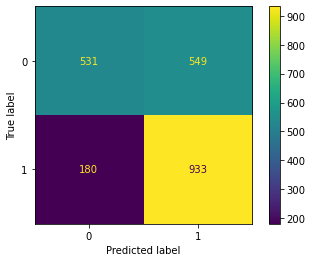

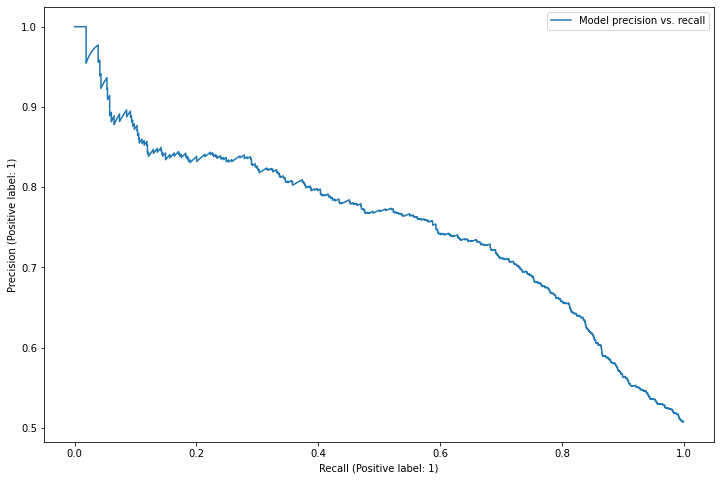

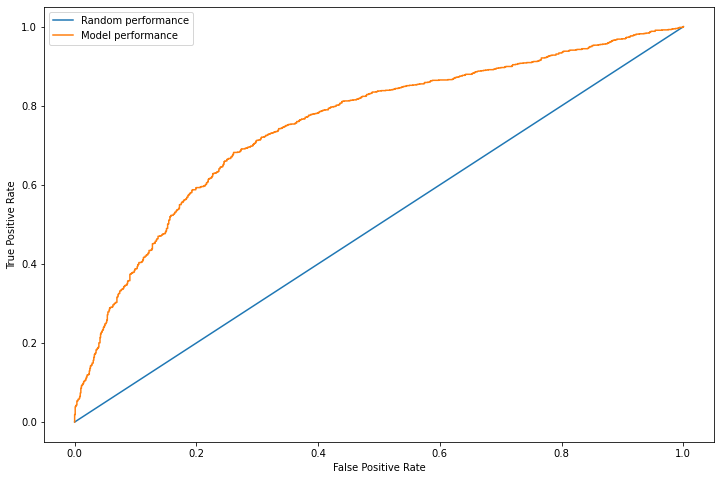

In [17]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [20]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-conv1d-LSTM-undersampling' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-conv1d-LSTM-undersampling20210527-0016


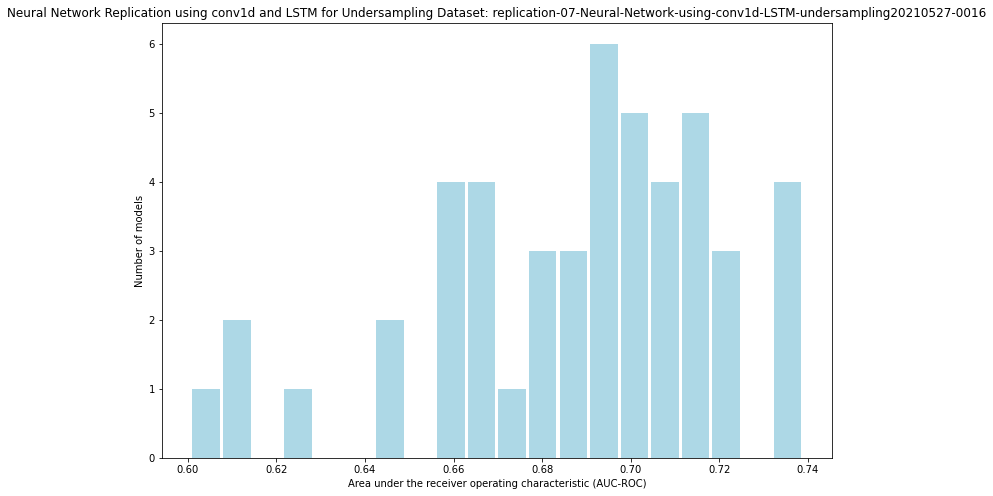

In [21]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using conv1d and LSTM for Undersampling Dataset: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)